In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
from astropy.convolution import convolve, Box1DKernel,  Gaussian1DKernel
from scipy.interpolate import interp1d

import astropy.units as u
from astropy import time, coordinates as coord
import astropy.constants as const
from astropy.modeling import models, fitting
from matplotlib.gridspec import GridSpec


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

HATS-72 FUV spectra are a non-detection, optical and NUV better? 

In [2]:
path = '/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/'
x1ds = np.hstack((glob.glob('{}*x1d.fits'.format(path)), glob.glob('{}*sx1.fits'.format(path))))
x1ds

array(['/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo29010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo29020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo29030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo29040_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo30010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo30020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo30030_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo30040_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo31010_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo31020_x1d.fits',
       '/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo31030_sx1.fits'],
      dtype='<U67')

/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo29010_x1d.fits
G140L
/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo29020_x1d.fits
G140L
/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo29030_x1d.fits
G140L
/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo29040_x1d.fits
G140L
/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo30010_x1d.fits
G140L
/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo30020_x1d.fits
G140L
/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo30030_x1d.fits
G140L
/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo30040_x1d.fits
G140L
/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo31010_x1d.fits
G230L
[504.05545]


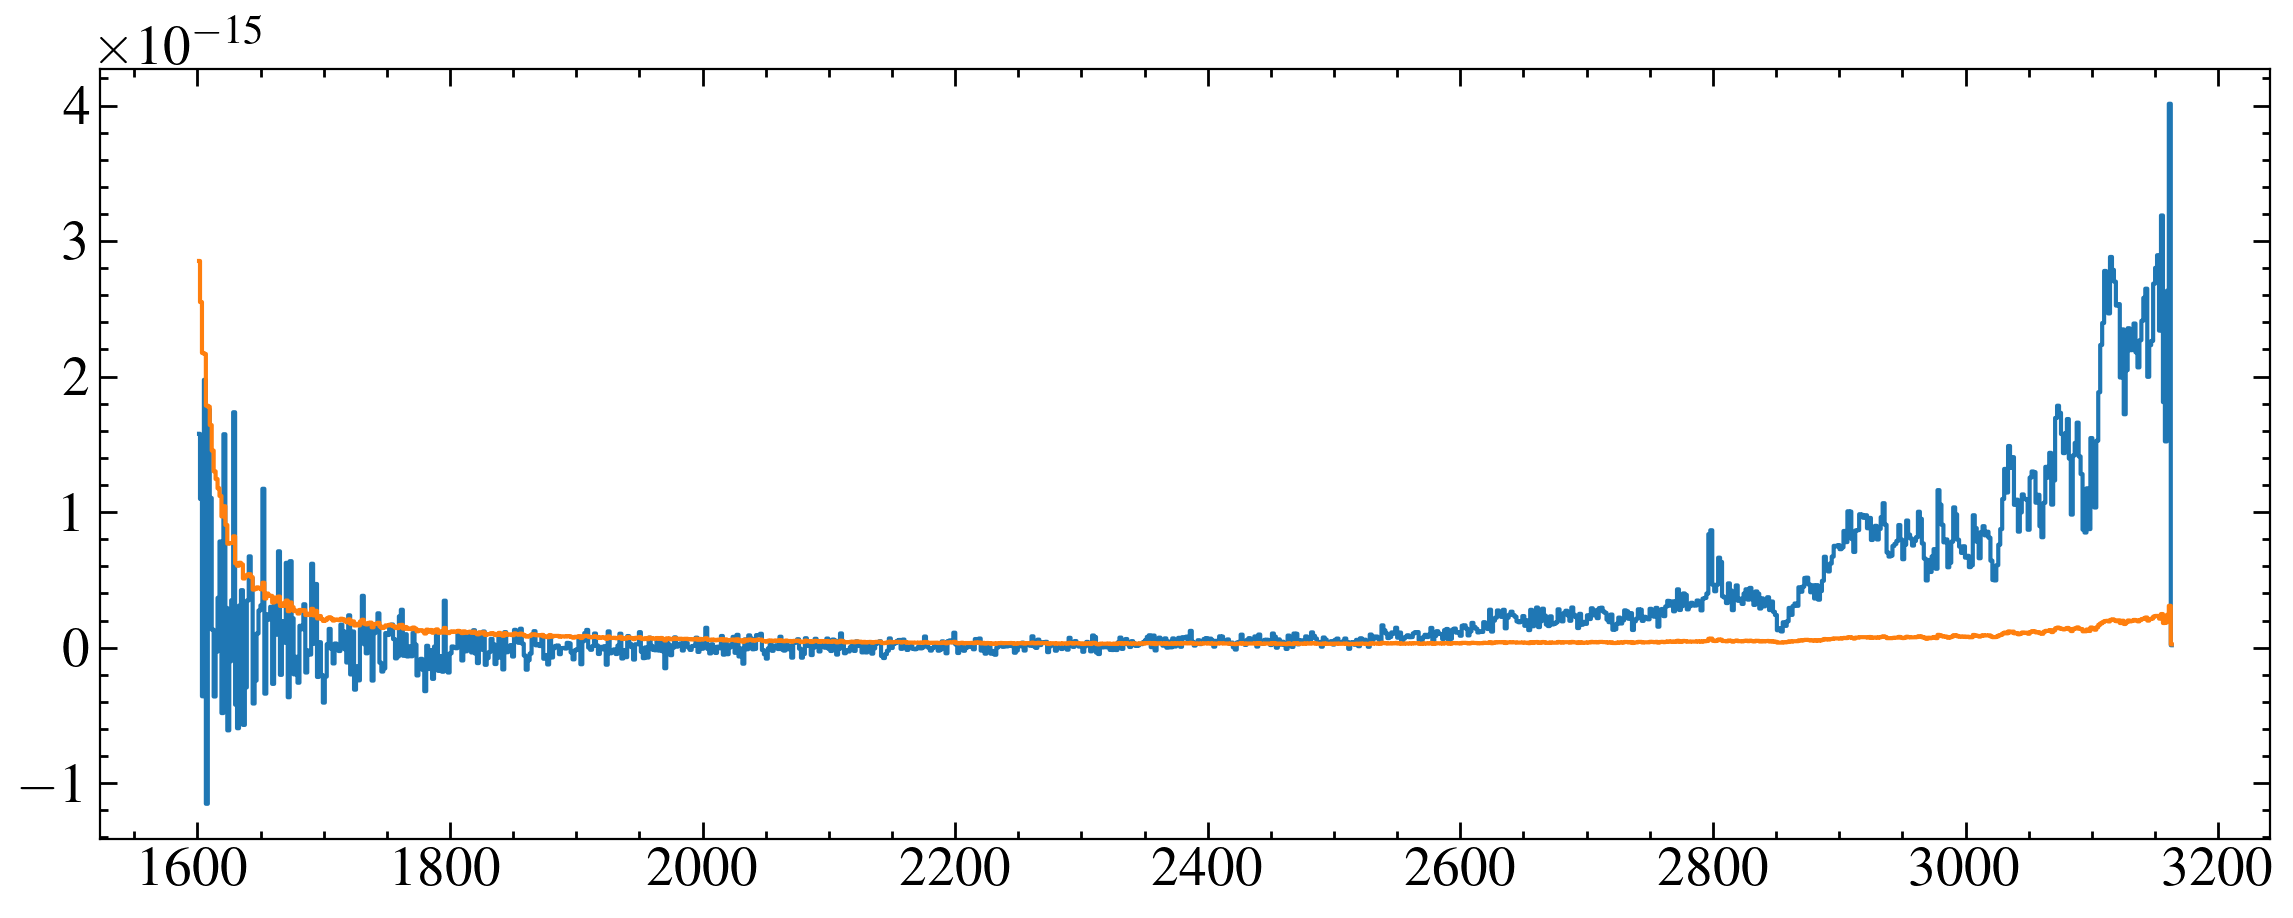

/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo31020_x1d.fits
G230L
[504.12897]


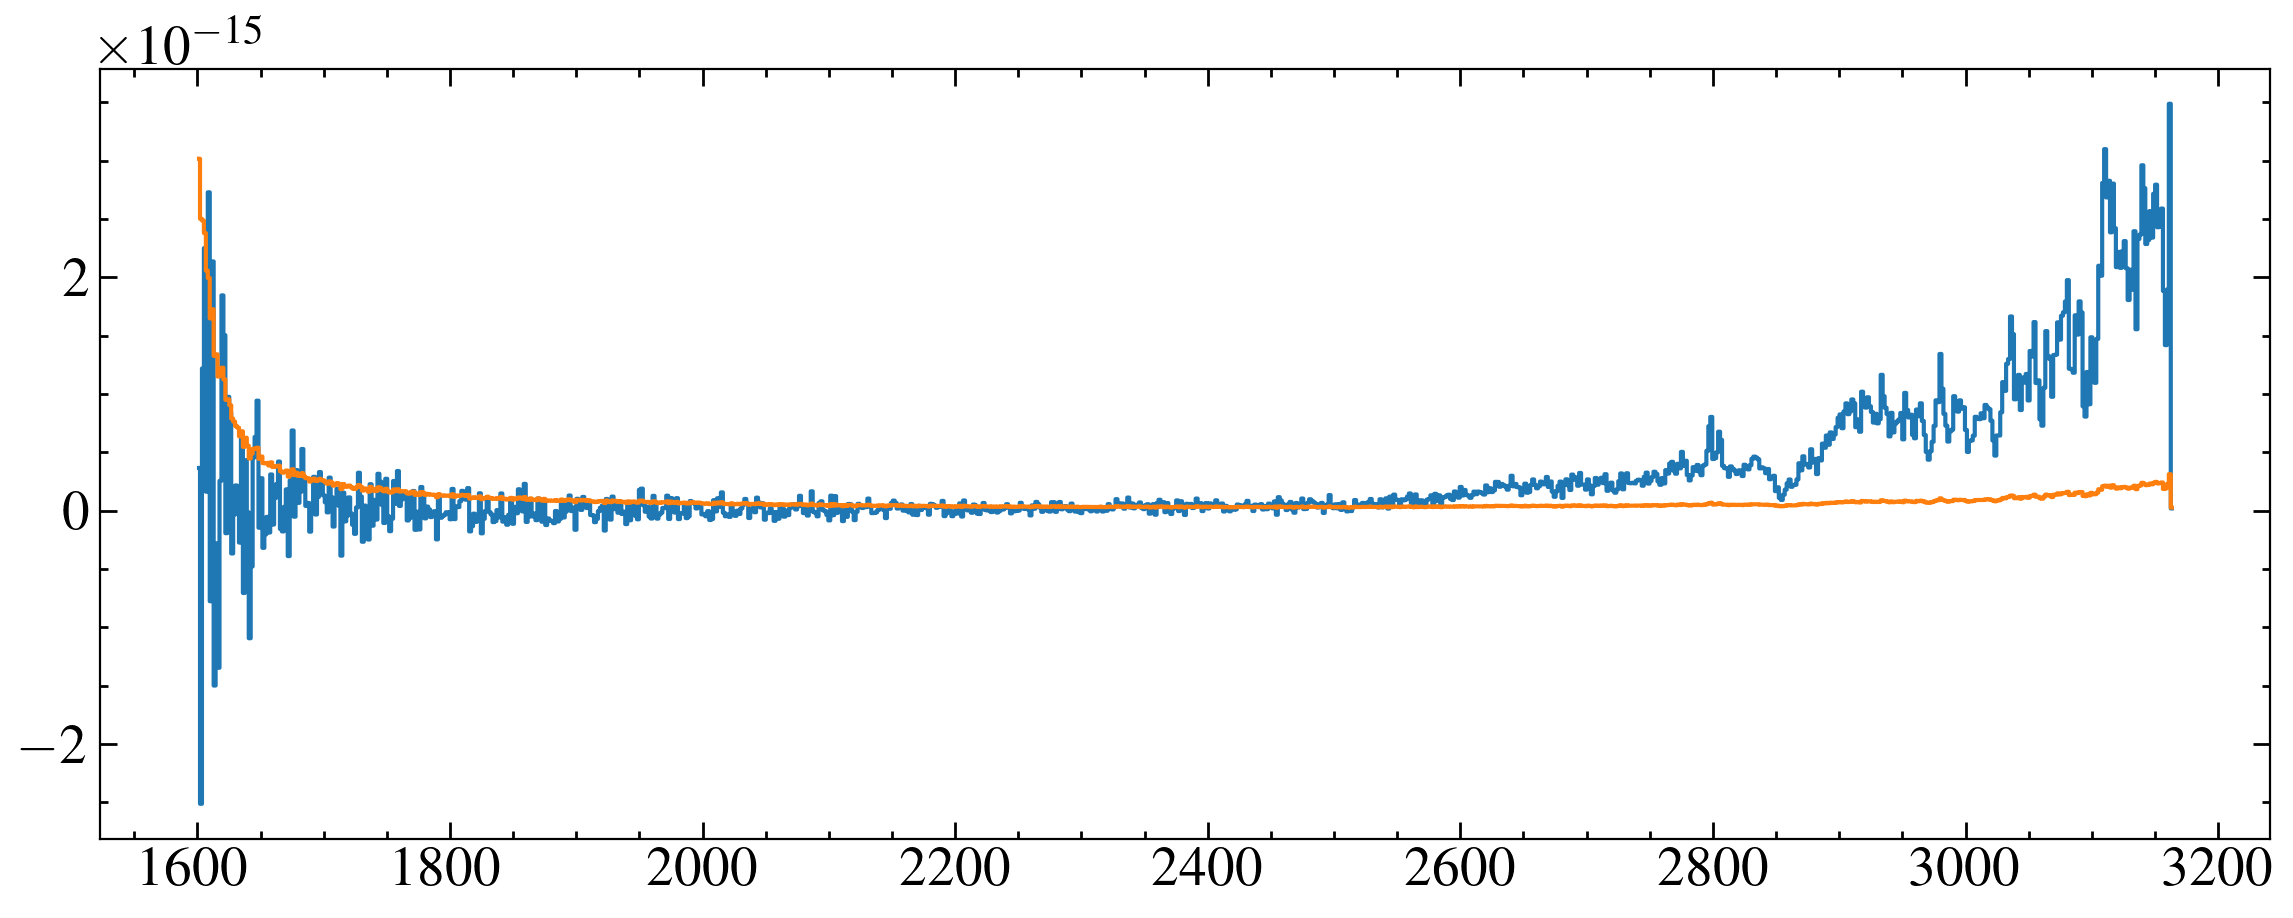

/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/oeoo31030_sx1.fits
G430L
[894.3394]


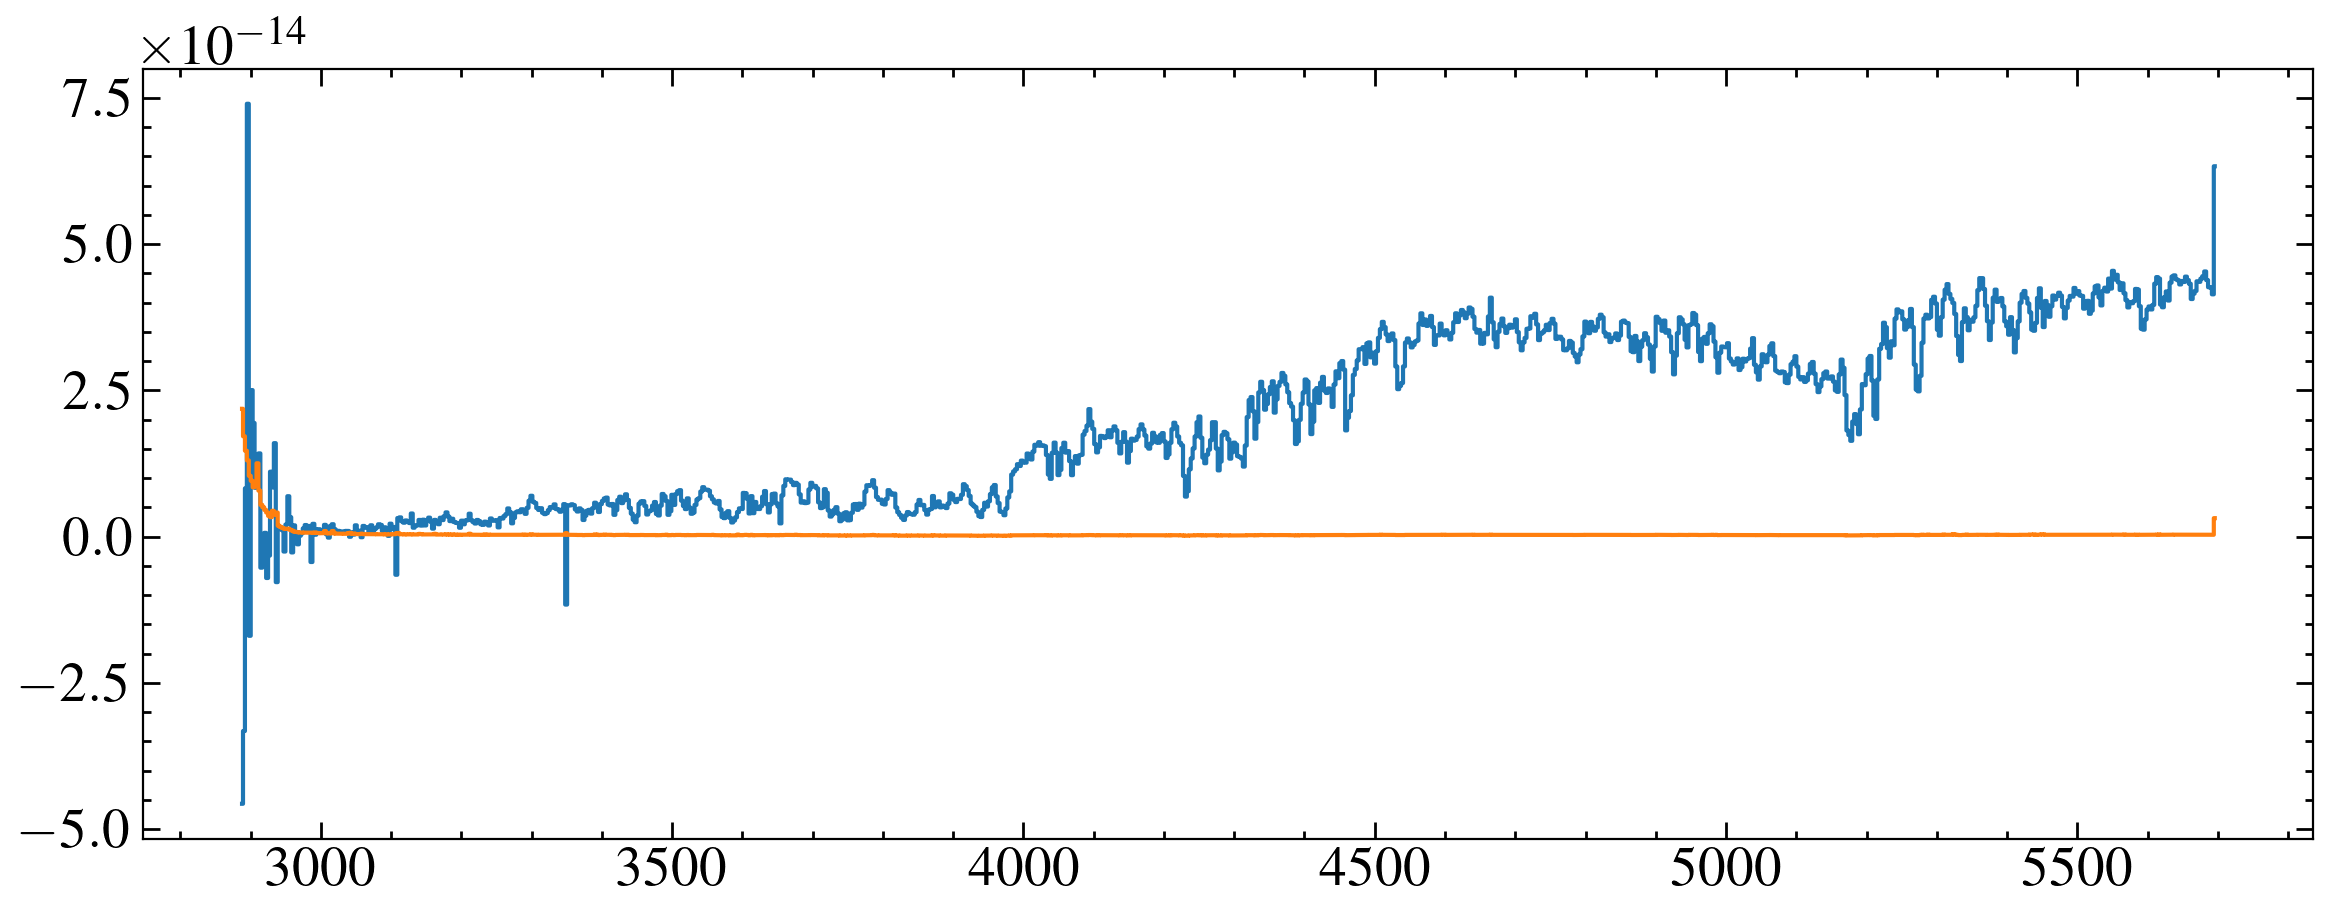

In [87]:
g140ls = []

for x in x1ds:
    print(x)
    grating = fits.getheader(x, 0)['OPT_ELEM'] 
    print(grating)
    if grating == 'G140L':
        g140ls.append(x)
    if grating in ['G230L', 'G430L']: 
        data = fits.getdata(x, 1)
        print(data['A2Center'])
        w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
        mask = w > 1600
        w, f, e = w[mask], f[mask], e[mask]
        plt.step(w, f, where='mid', c='C0')
        plt.step(w, e, where='mid', c='C1')
        plt.show()

    

eps Ind is the proxy. 

/home/david/work/meats/SEDs/prepare_stis.py:36: RuntimeWarning: divide by zero encountered in divide
  weights = 1 / (e_array**2)
/home/david/micromamba/envs/stenv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:587: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


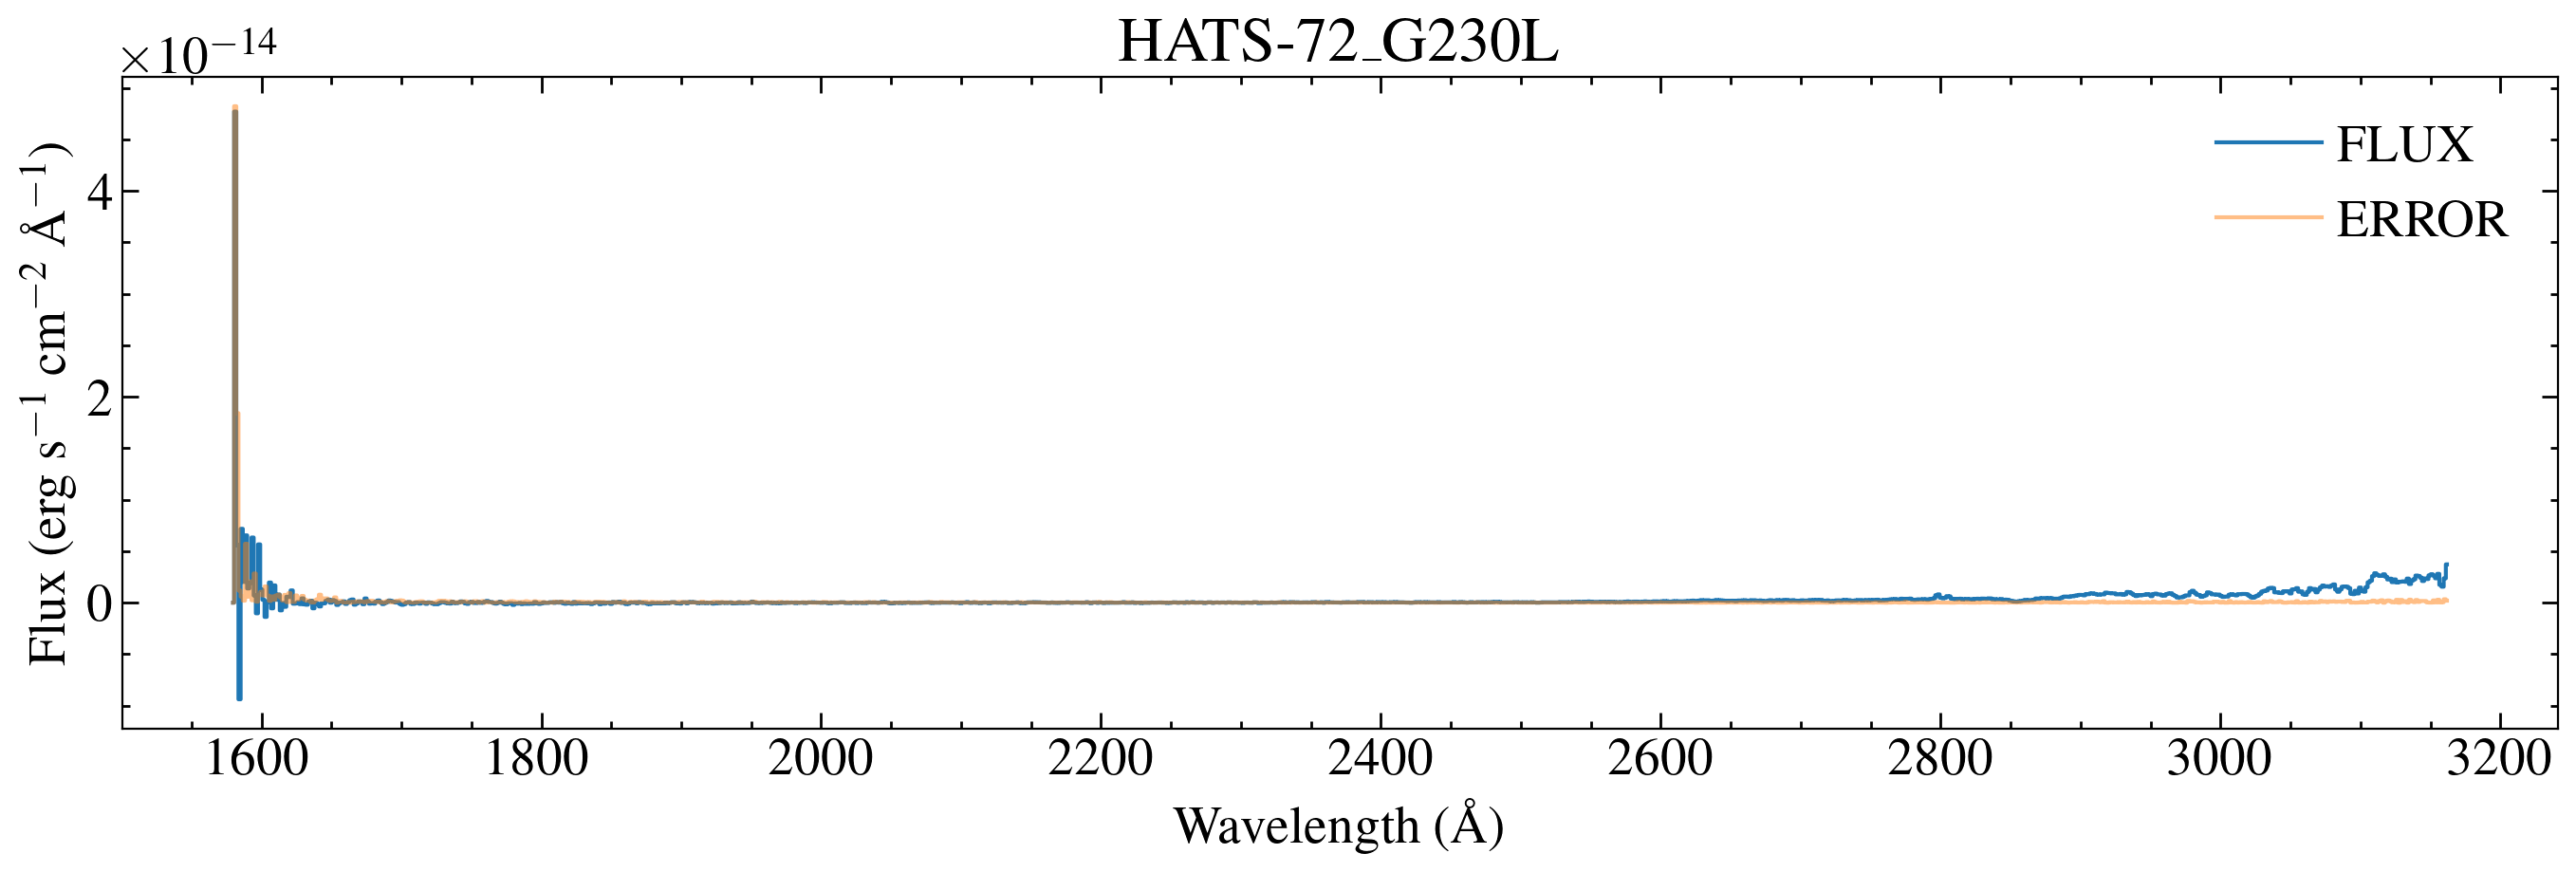

Spectrum saved as hlsp_muscles_hst_stis_hats-72_g230l_v1_component-spec.fits


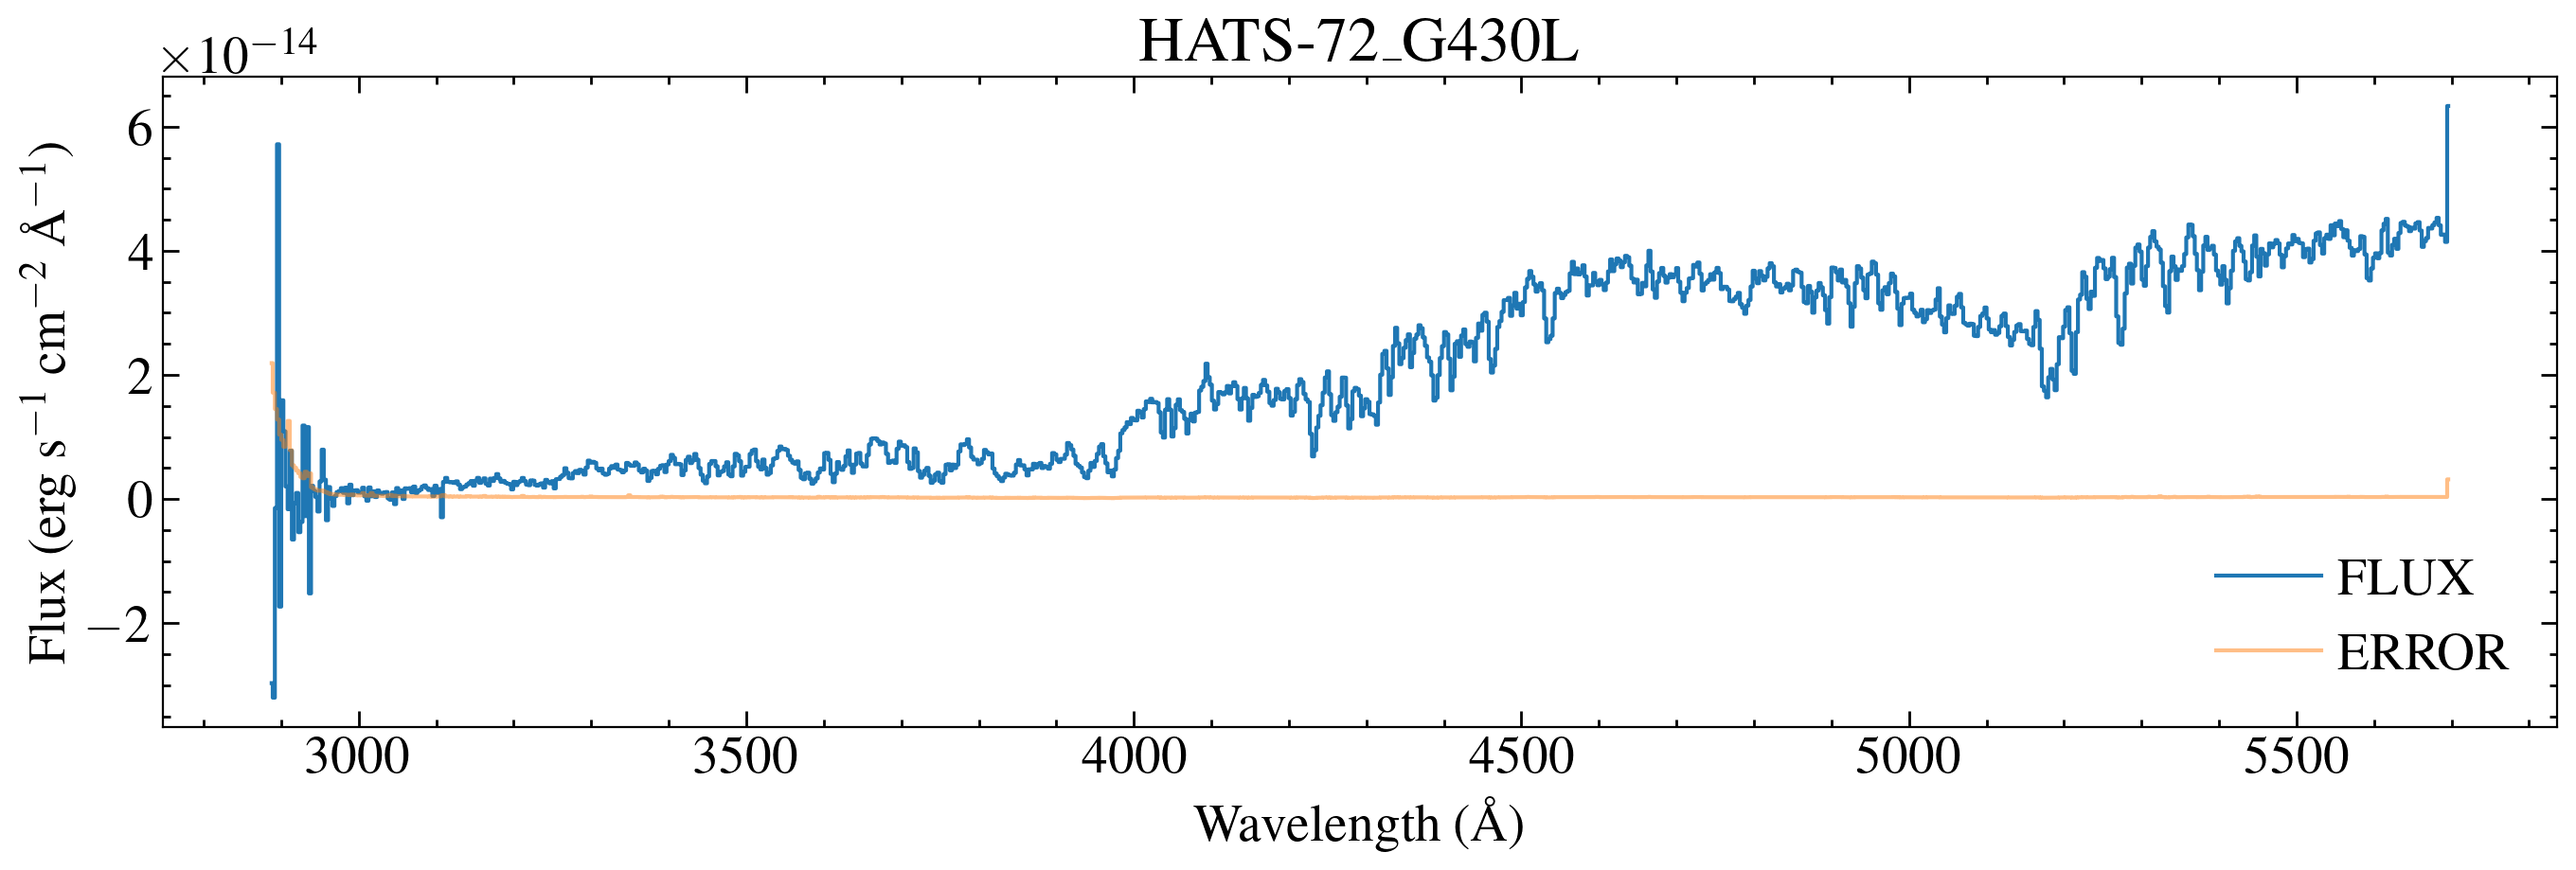

Spectrum saved as hlsp_muscles_hst_stis_hats-72_g430l_v1_component-spec.fits


In [4]:
import prepare_stis
x1dpath = '/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/use_spectra/'
savepath = 'draft_hlsp/hats-72/'
hlsp = 'meats_hlsp_info.csv'
version = 1
prepare_stis.make_stis_spectrum(x1dpath, version, hlsp, savepath = savepath, plot=True, save_fits=True, normfac=1.0, star = 'HATS-72')


In [5]:
import prepare_phoenix_svo as pp
# importlib.reload(pp)

G = const.G
M = const.M_sun.to(u.kg)
R = const.R_sun.to(u.m)
mass = 0.7311
teff = 4656
teff_e = 9

radius = 0.7214
distance = 128.06

save_path = 'models/'
star = 'HATS-72'
# g = ((G*mass*M)/(radius*R)**2).to(u.cm/u.s**2)
g = 4.5853
repo = '/media/david/2tb_ext_hd/hddata/mega_muscles/data-vacuum/'

star_params = {'Teff': teff, 'Teff_e':teff_e,  'logg': g, 'FeH': 0.00, 'aM': 0, 'Radius':radius*u.R_sun, 'Distance':distance*u.pc}
# pw, pf, pe = pp.make_phoenix_spectrum(star, save_path, repo, star_params, save_ecsv=True, plot=True, make_error=True)
pdata = Table.read('models/{}_phoenix_interpolated.ecsv'.format(star))
pw, pf, pe = pdata['WAVELENGTH'], pdata['FLUX'], pdata['ERROR']
normfac = ((radius*R)/((distance*u.pc).to(u.m)))**2

In [6]:
hlsp_x1ds = glob.glob('draft_hlsp/hats-72/*stis*.fits')
hlsp_x1ds

['draft_hlsp/hats-72/hlsp_muscles_hst_stis_hats-72_g230l_v1_component-spec.fits',
 'draft_hlsp/hats-72/hlsp_muscles_hst_stis_hats-72_g430l_v1_component-spec.fits']

In [7]:
from dust_extinction.parameter_averages import F99
print(0.027/3.1)

0.008709677419354838


draft_hlsp/hats-72/hlsp_muscles_hst_stis_hats-72_g230l_v1_component-spec.fits
draft_hlsp/hats-72/hlsp_muscles_hst_stis_hats-72_g430l_v1_component-spec.fits


(1e-17, 5e-14)

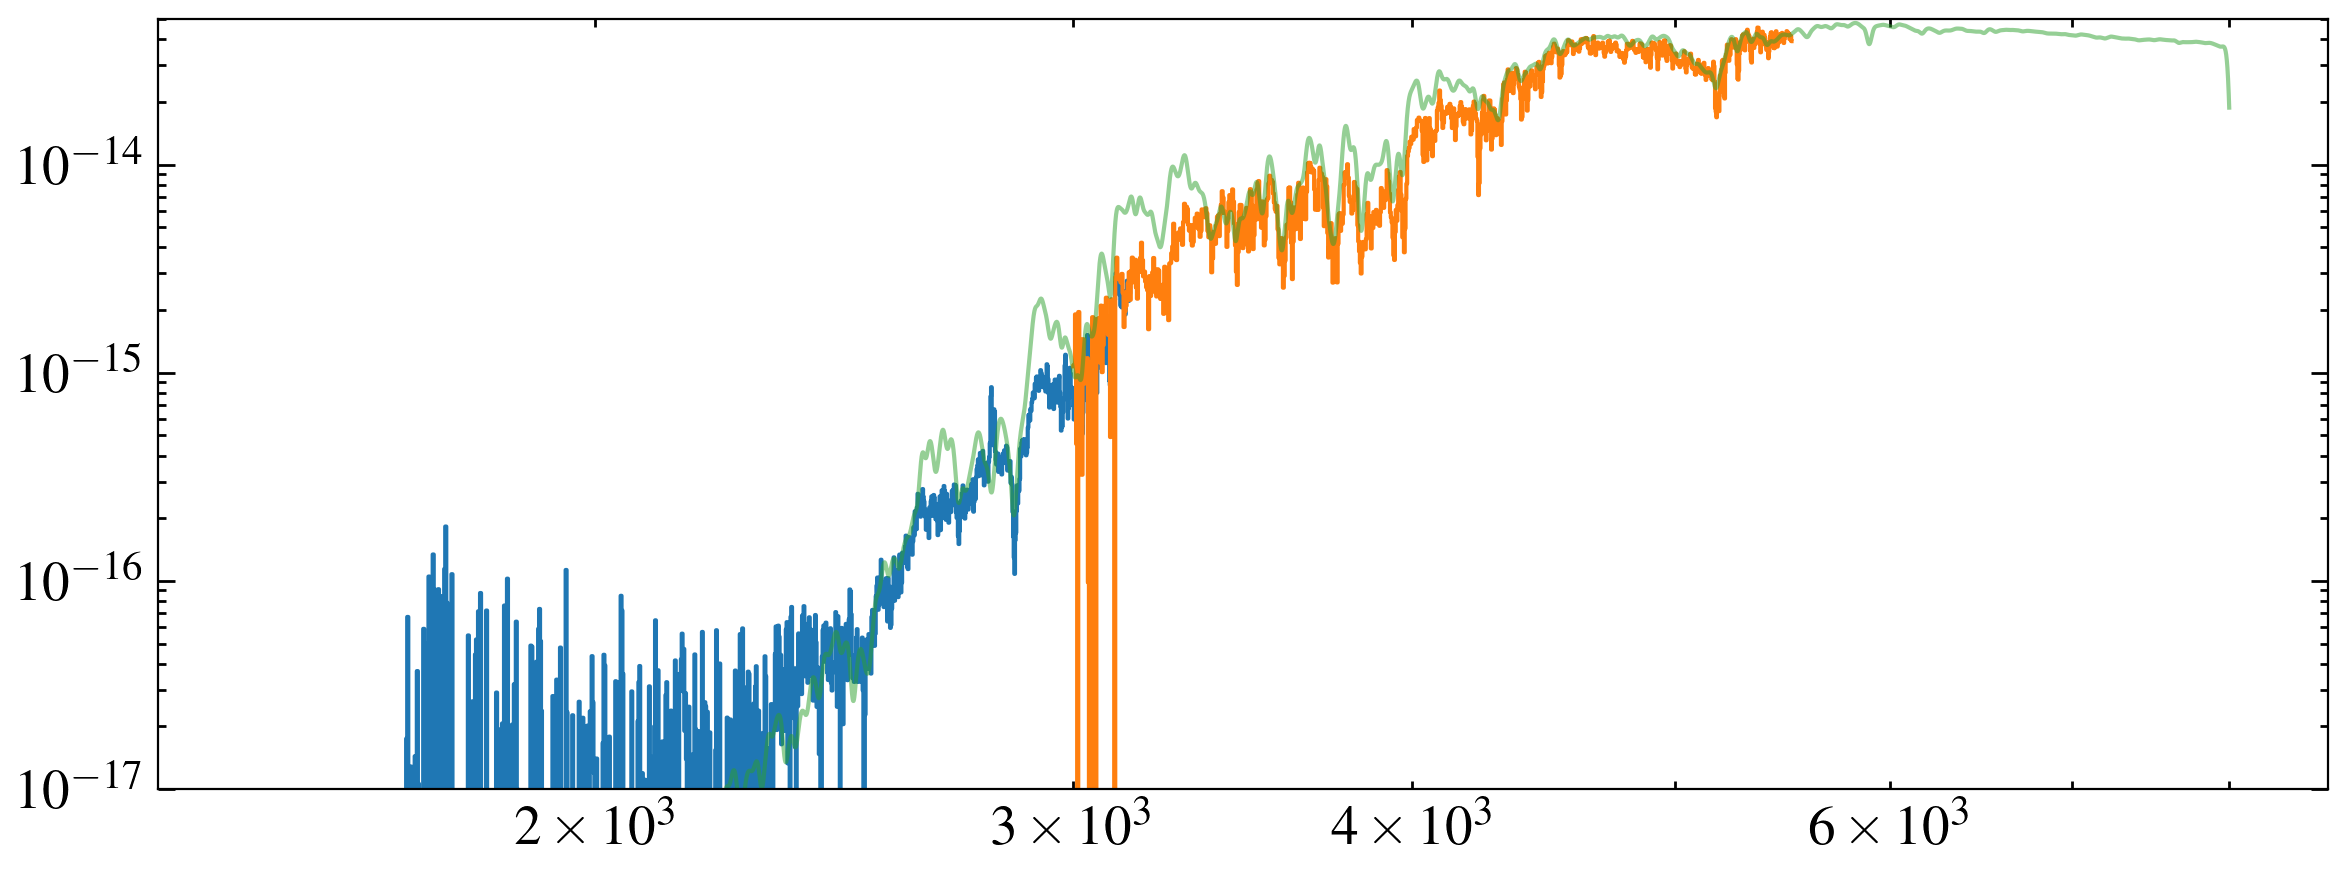

In [8]:
fig, ax = plt.subplots()
ext = F99(Rv=3.1)


for x in [hlsp_x1ds[0], hlsp_x1ds[1]]:
    print(x)
    grating = fits.getheader(x, 0)['GRATING'] 
    data = fits.getdata(x, 1)
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     if grating in ['G140M', 'G140L']:
#         mask = (w > 1160)
        
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
    if grating =='G230L':
        mask = (w > 1700) & (w < 3150)
    if grating =='G430L':
        mask = (w > 3000) & (w < 5520)
    
    w, f, e = w[mask], f[mask], e[mask]
    red = ext.extinguish(w*u.AA, Ebv = 0.01)

    
    ax.step(w, f/red, where='mid')
    
#     plt.step(w, e, where='mid')
#     plt.show()
   
pmask = (pw > 1500) & (pw < 8000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi,500)
ax.plot(pwi, pfi, alpha=0.5)
    
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim(1e-17, 0.5e-13)


In [9]:
import prepare_model
hdr = fits.getheader('draft_hlsp/hats-72/hlsp_muscles_hst_stis_hats-72_g230l_v1_component-spec.fits', 0)
sed_data = Table(meta=hdr)
# prepare_model.make_model_spectrum('models/eps_Indi_apec_errs.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1.0, model_name='apec')
#PHX
prepare_model.make_model_spectrum('models/eps_indi_phoenix_interpolated.ecsv', 1, sed_data,
                                  savepath = savepath, save_ecsv=False, save_fits=True, normfac=normfac.value, model_name='PHX')


Spectrum saved as hlsp_muscles_model_phx_hats-72_na_v1_component-spec.fits


In [10]:
# prox = fits.getdata('draft_hlsp/eps_indi/hlsp_muscles_multi_multi_eps_indi_broadband_v1_adapt-var-res-sed.fits', 1)
prox = fits.getdata('draft_hlsp/eps_indi/hlsp_muscles_hst_stis_eps_indi_e230h_v1_component-spec.fits', 1)
wprox, fprox = prox['WAVELENGTH'], prox['FLUX']

draft_hlsp/hats-72/hlsp_muscles_hst_stis_hats-72_g230l_v1_component-spec.fits
draft_hlsp/hats-72/hlsp_muscles_hst_stis_hats-72_g430l_v1_component-spec.fits
0.0008072236754357954


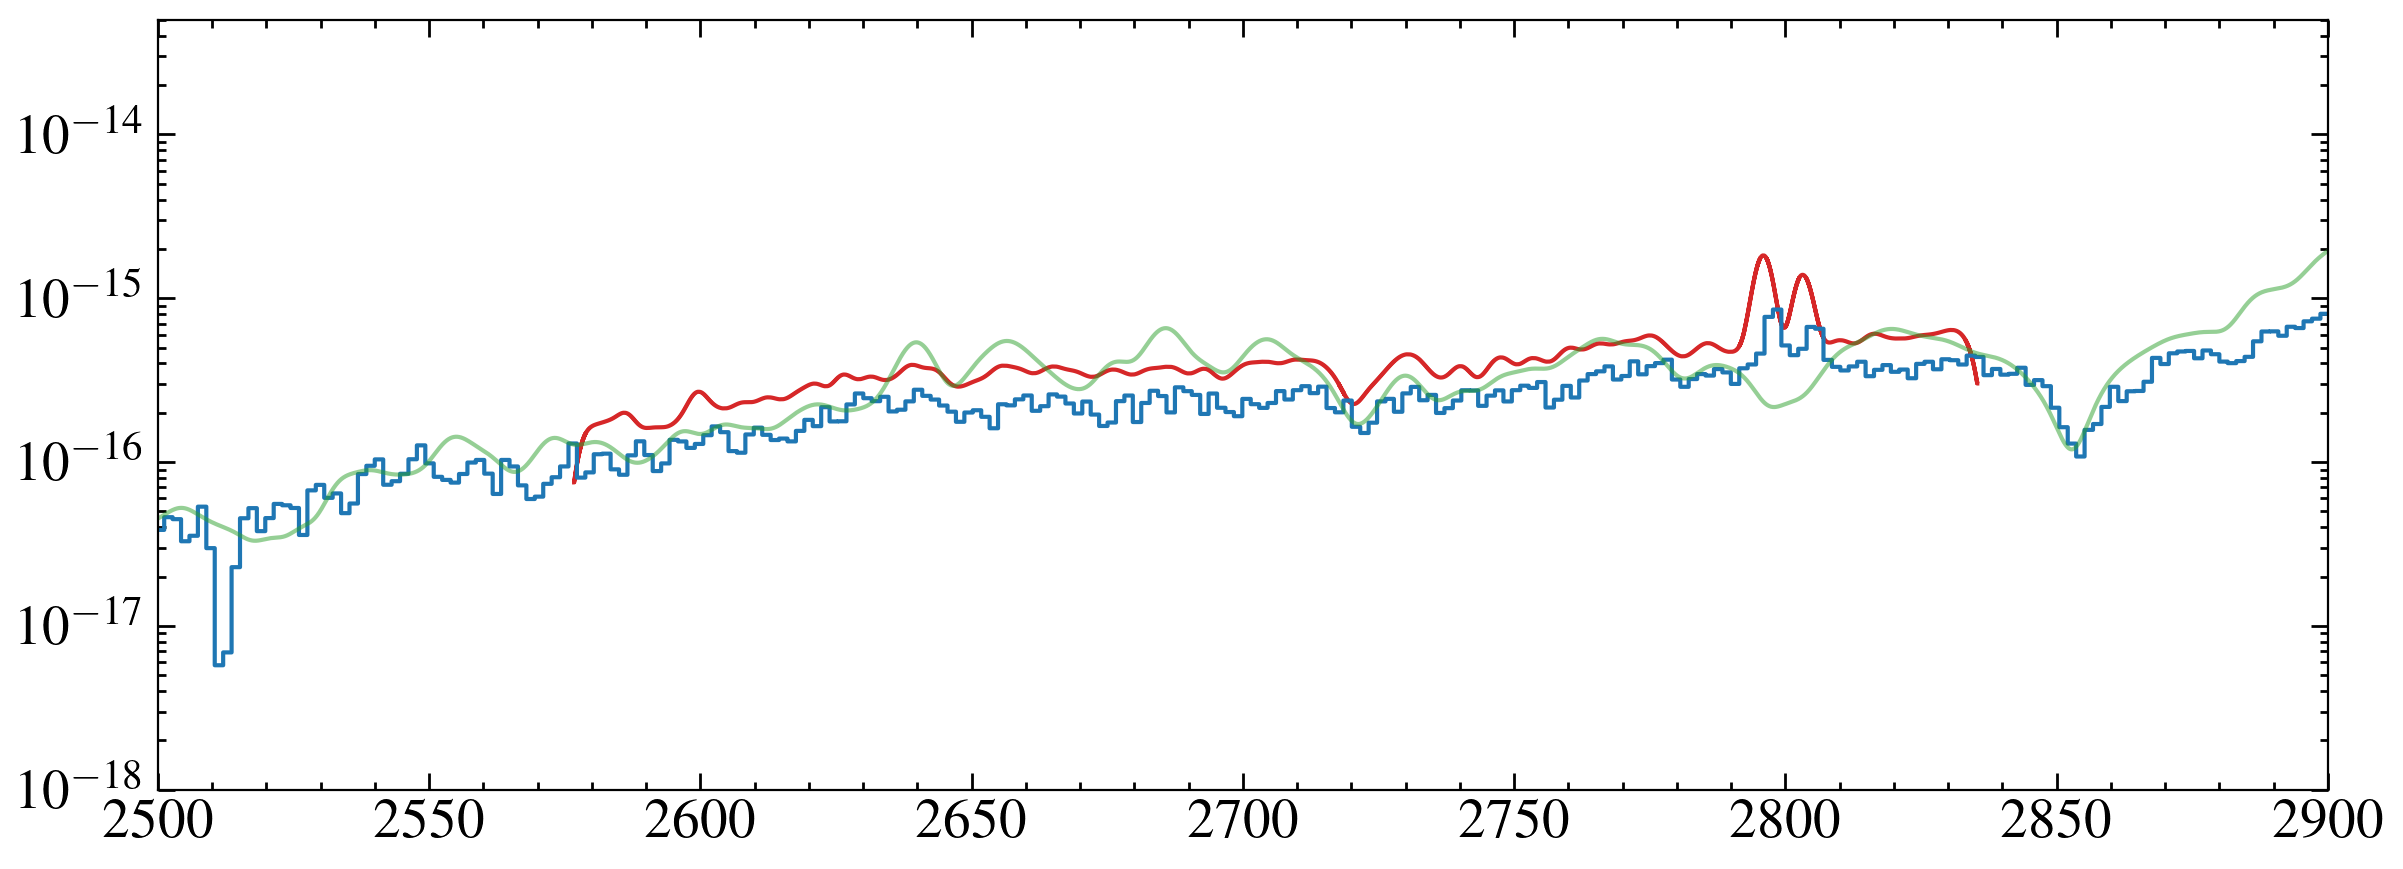

In [11]:
dprox = 3.6384
rprox = 0.736
fig, ax = plt.subplots()
ext = F99(Rv=3.1)


for x in [hlsp_x1ds[0], hlsp_x1ds[1]]:
    print(x)
    grating = fits.getheader(x, 0)['GRATING'] 
    data = fits.getdata(x, 1)
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     if grating in ['G140M', 'G140L']:
#         mask = (w > 1160)
        
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
    if grating =='G230L':
        mask = (w > 1700) & (w < 3150)
    if grating =='G430L':
        mask = (w > 3000) & (w < 5520)
    
    w, f, e = w[mask], f[mask], e[mask]
    red = ext.extinguish(w*u.AA, Ebv = 0.01)

    
    ax.step(w, f/red, where='mid')
    
#     plt.step(w, e, where='mid')
#     plt.show()
   
pmask = (pw > 1500) & (pw < 8000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi,1000)
ax.plot(pwi, pfi, alpha=0.5)
    
ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_ylim(1e-18, 0.5e-13)

ax.set_xlim(2500, 2900)

proxscale = (dprox/distance)**2 #* (rprox/radius)**2
print(proxscale)

proxmask = (wprox < 8000)

# fproxi = convolve(fprox, Box1DKernel(500))
respix = (wprox[-1] - wprox[0])/len(wprox)
# print(respix)
FWHM = 4/respix 
sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))


fproxi = convolve(fprox, Gaussian1DKernel(sigma))


ax.step(wprox[proxmask], fproxi[proxmask]*proxscale, zorder=-1, where='mid')


Scale the eps Indi g230H spectrum to the HATS-72 G230L spectrum.

<>:53: SyntaxWarning: invalid escape sequence '\A'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\A'
<>:53: SyntaxWarning: invalid escape sequence '\A'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:56: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_192892/1967883461.py:53: SyntaxWarning: invalid escape sequence '\A'
  ax.set_ylabel('Flux (10$^-15$ \n erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
/tmp/ipykernel_192892/1967883461.py:55: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel('$F_{\mathrm{prox}}/F_{*}$')
/tmp/ipykernel_192892/1967883461.py:56: SyntaxWarning: invalid escape sequence '\A'
  ax1.set_xlabel('Wavelength (\AA)')


0.0005273812835774858


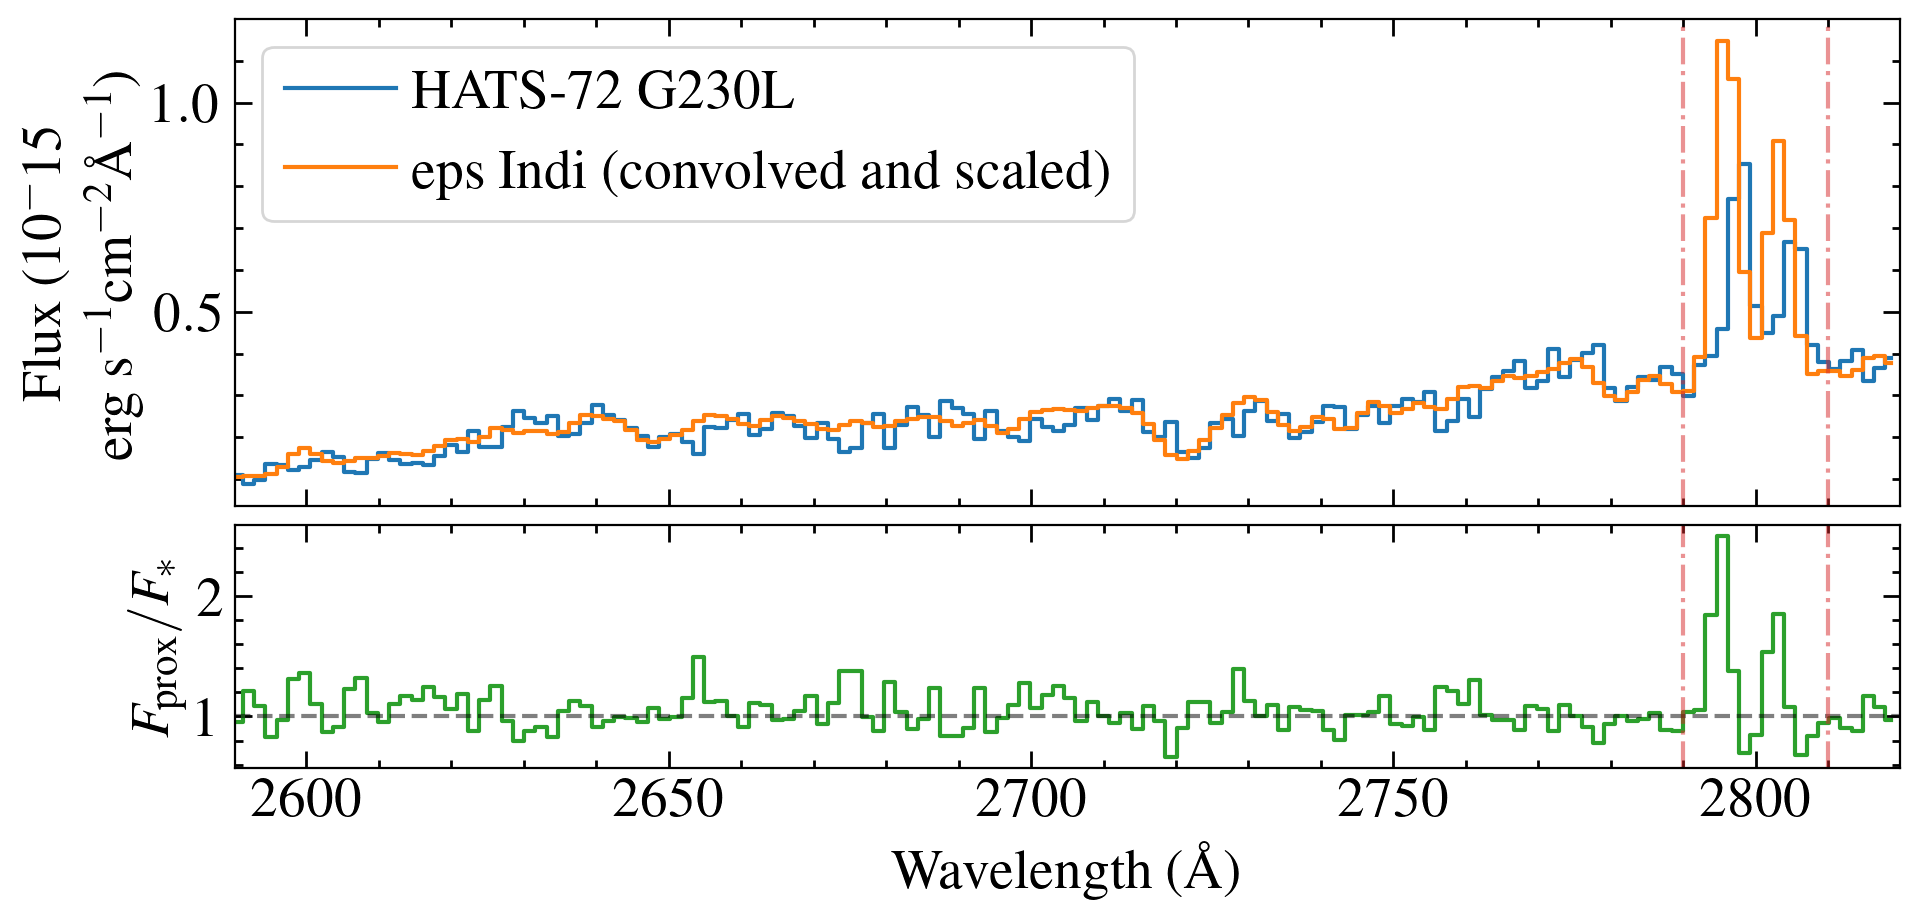

In [12]:
from scipy.optimize import leastsq

def residuals(scale, f, mf):
    return f - mf/scale

scale = 1e15

g230l = fits.getdata(hlsp_x1ds[0], 1)
gw, gf, ge= g230l['WAVELENGTH'], g230l['FLUX'], g230l['ERROR']
e230h = fits.getdata('draft_hlsp/eps_indi/hlsp_muscles_hst_stis_eps_indi_e230h_v1_component-spec.fits', 1)
ew, ef, ee = e230h['WAVELENGTH'], e230h['FLUX'], e230h['ERROR']

respix = (ew[-1] - ew[0])/len(ew)
FWHM = 4/respix 
sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))
efi = convolve(ef, Gaussian1DKernel(sigma))

fig, axs = plt.subplots(nrows = 2, height_ratios=[2,1], sharex=True, figsize=(10,5))

ax= axs[0]
mask = (gw > 2590) & (gw < 2820)

gwi, gfi = gw[mask], gf[mask]
red = ext.extinguish(gwi*u.AA, Ebv = 0.01)
gfi = gfi/red

ax.step(gwi, gfi*scale, where='mid', label='HATS-72 G230L')
# ax.step(ew, efi, where='mid')


efi = np.interp(gw[mask],ew, efi,) 

mglims = [2790, 2810]
mgmask = (gwi <mglims[0]) | (gwi > mglims[1]) 

norm = leastsq(residuals, 1., args=(efi[mgmask], gfi[mgmask]))[0][0]
print(norm)

ax.step(gwi, efi*norm*scale, where='mid', label='eps Indi (convolved and scaled)')

ax1=axs[1]

ax1.step(gwi, (efi*norm)/gfi, where='mid', c='C2')

ax1.axhline(1, ls='--', c='k', alpha=0.5)

[[a.axvline(line, ls='-.', c='C3', alpha=0.5) for line in mglims] for a in axs]
# [ax1.axvline(line, ls='-.', c='C3', alpha=0.5) for line in mglims]
#should I measure the velocities first? Nah just mask mgii

ax.legend(frameon=True)
ax.set_xlim(2590.1, 2819.9)
ax.set_ylabel('Flux (10$^-15$ \n erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')

ax1.set_ylabel('$F_{\mathrm{prox}}/F_{*}$')
ax1.set_xlabel('Wavelength (\AA)')

fig.tight_layout()
fig.subplots_adjust(hspace=0.05)

fig.savefig('plots/hats72_proxy.pdf')

How does that look?

In [13]:
prox = fits.getdata('draft_hlsp/eps_indi/hlsp_muscles_multi_multi_eps_indi_broadband_v1_adapt-var-res-sed.fits', 1)
# prox = fits.getdata('draft_hlsp/eps_indi/hlsp_muscles_hst_stis_eps_indi_e230h_v1_component-spec.fits', 1)
wprox, fprox = prox['WAVELENGTH'], prox['FLUX']

draft_hlsp/hats-72/hlsp_muscles_hst_stis_hats-72_g230l_v1_component-spec.fits
draft_hlsp/hats-72/hlsp_muscles_hst_stis_hats-72_g430l_v1_component-spec.fits


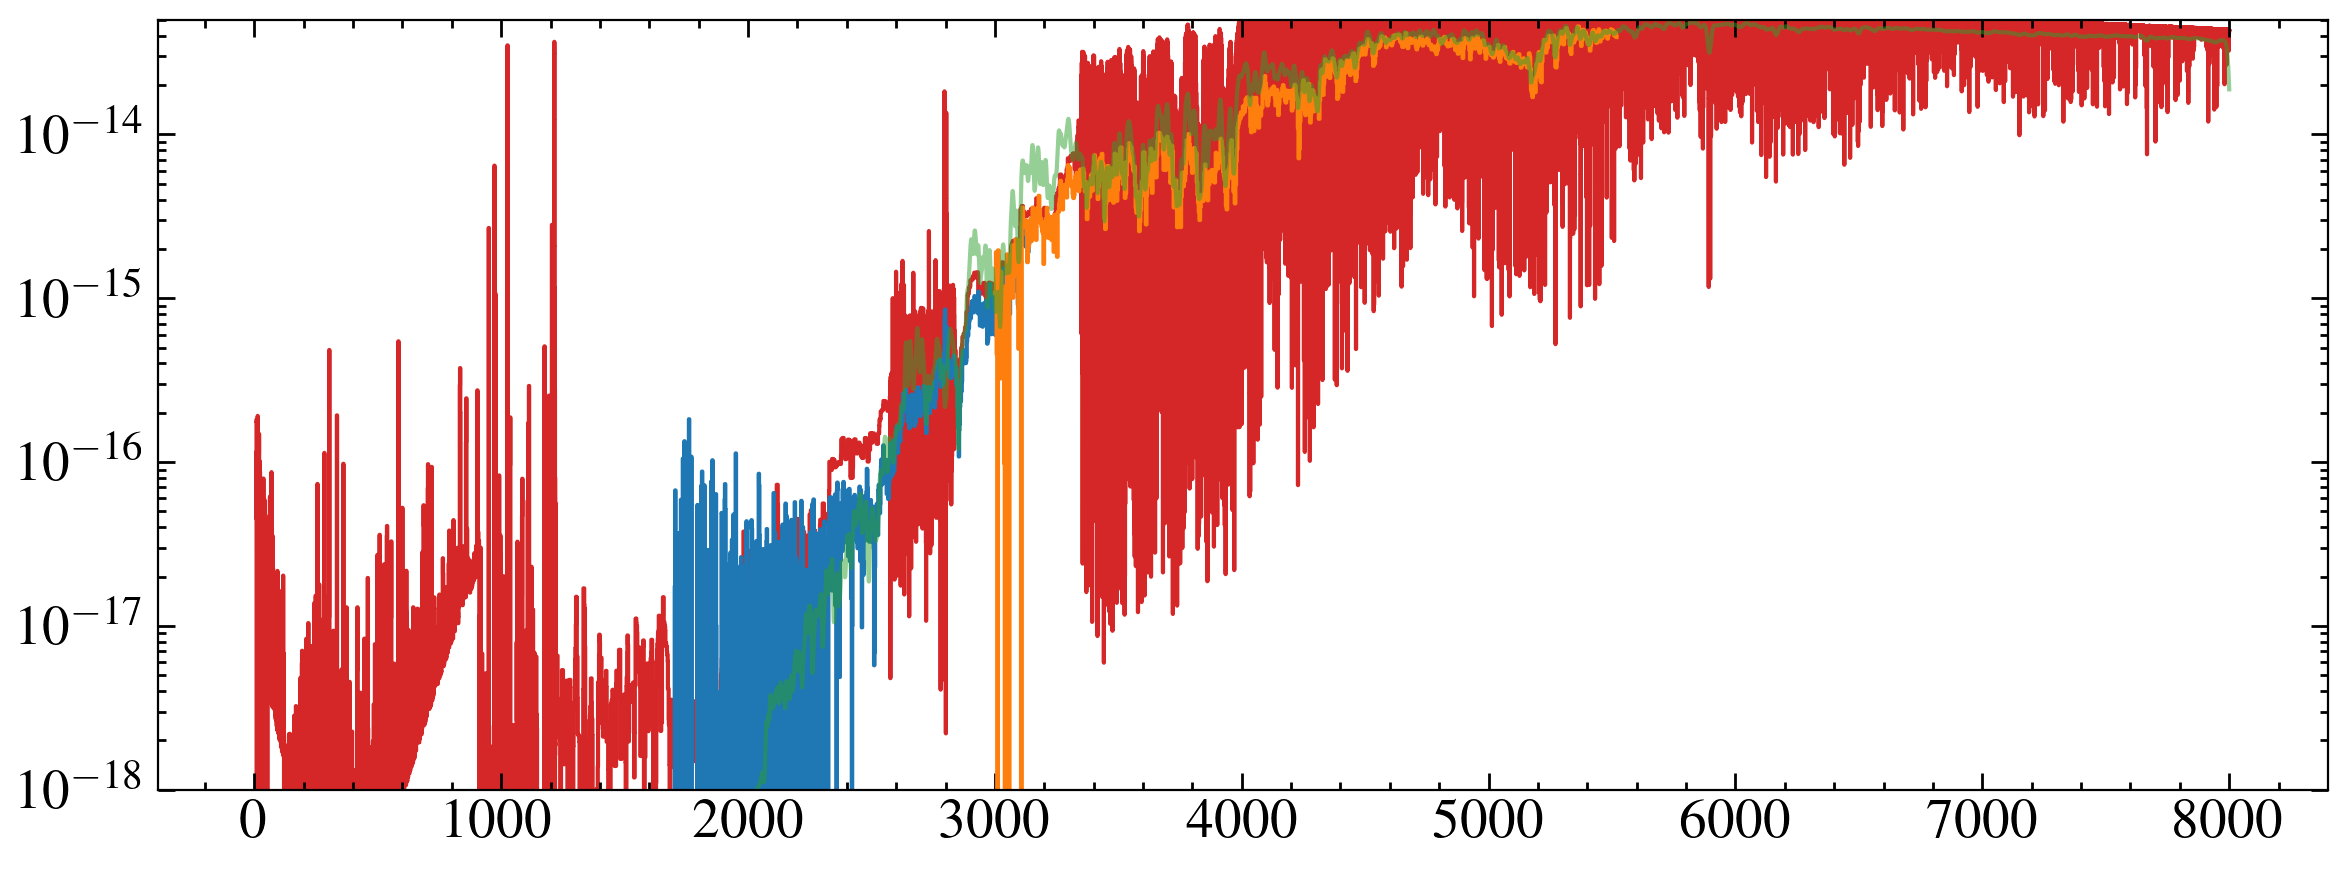

In [14]:
dprox = 3.6384
rprox = 0.736
fig, ax = plt.subplots()
ext = F99(Rv=3.1)


for x in [hlsp_x1ds[0], hlsp_x1ds[1]]:
    print(x)
    grating = fits.getheader(x, 0)['GRATING'] 
    data = fits.getdata(x, 1)
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
#     if grating in ['G140M', 'G140L']:
#         mask = (w > 1160)
        
        # plt.ylim(-1e-16, 1e-16)
        # plt.axhline(0, ls='--', c='0.5')
    if grating =='G230L':
        mask = (w > 1700) & (w < 3150)
    if grating =='G430L':
        mask = (w > 3000) & (w < 5520)
    
    w, f, e = w[mask], f[mask], e[mask]
    red = ext.extinguish(w*u.AA, Ebv = 0.01)

    
    ax.step(w, f/red, where='mid')
    
#     plt.step(w, e, where='mid')
#     plt.show()
   
pmask = (pw > 1500) & (pw < 8000)
pwi, pfi = pw[pmask], pf[pmask]*normfac
pwi, pfi = pp.smear(pwi, pfi,1000)
ax.plot(pwi, pfi, alpha=0.5)
    
ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_ylim(1e-18, 0.5e-13)

# ax.set_xlim(2500, 2900)

# proxscale = (dprox/distance)**2 #* (rprox/radius)**2
# print(proxscale)

# proxscale=norm
# print(prox)

proxmask = (wprox < 8000)

# fproxi = convolve(fprox, Box1DKernel(500))
respix = (wprox[-1] - wprox[0])/len(wprox)
# print(respix)
FWHM = 4/respix 
sigma = FWHM / (2 * np.sqrt(2 * np.log(2)))


fproxi = convolve(fprox, Gaussian1DKernel(sigma))


ax.step(wprox[proxmask], fproxi[proxmask]*proxscale, zorder=-1, where='mid')


That'll do. Maybe I should go back and rescale the eps Indi IUE spectrum to the E230H spectrum. Nope. Where to chop?

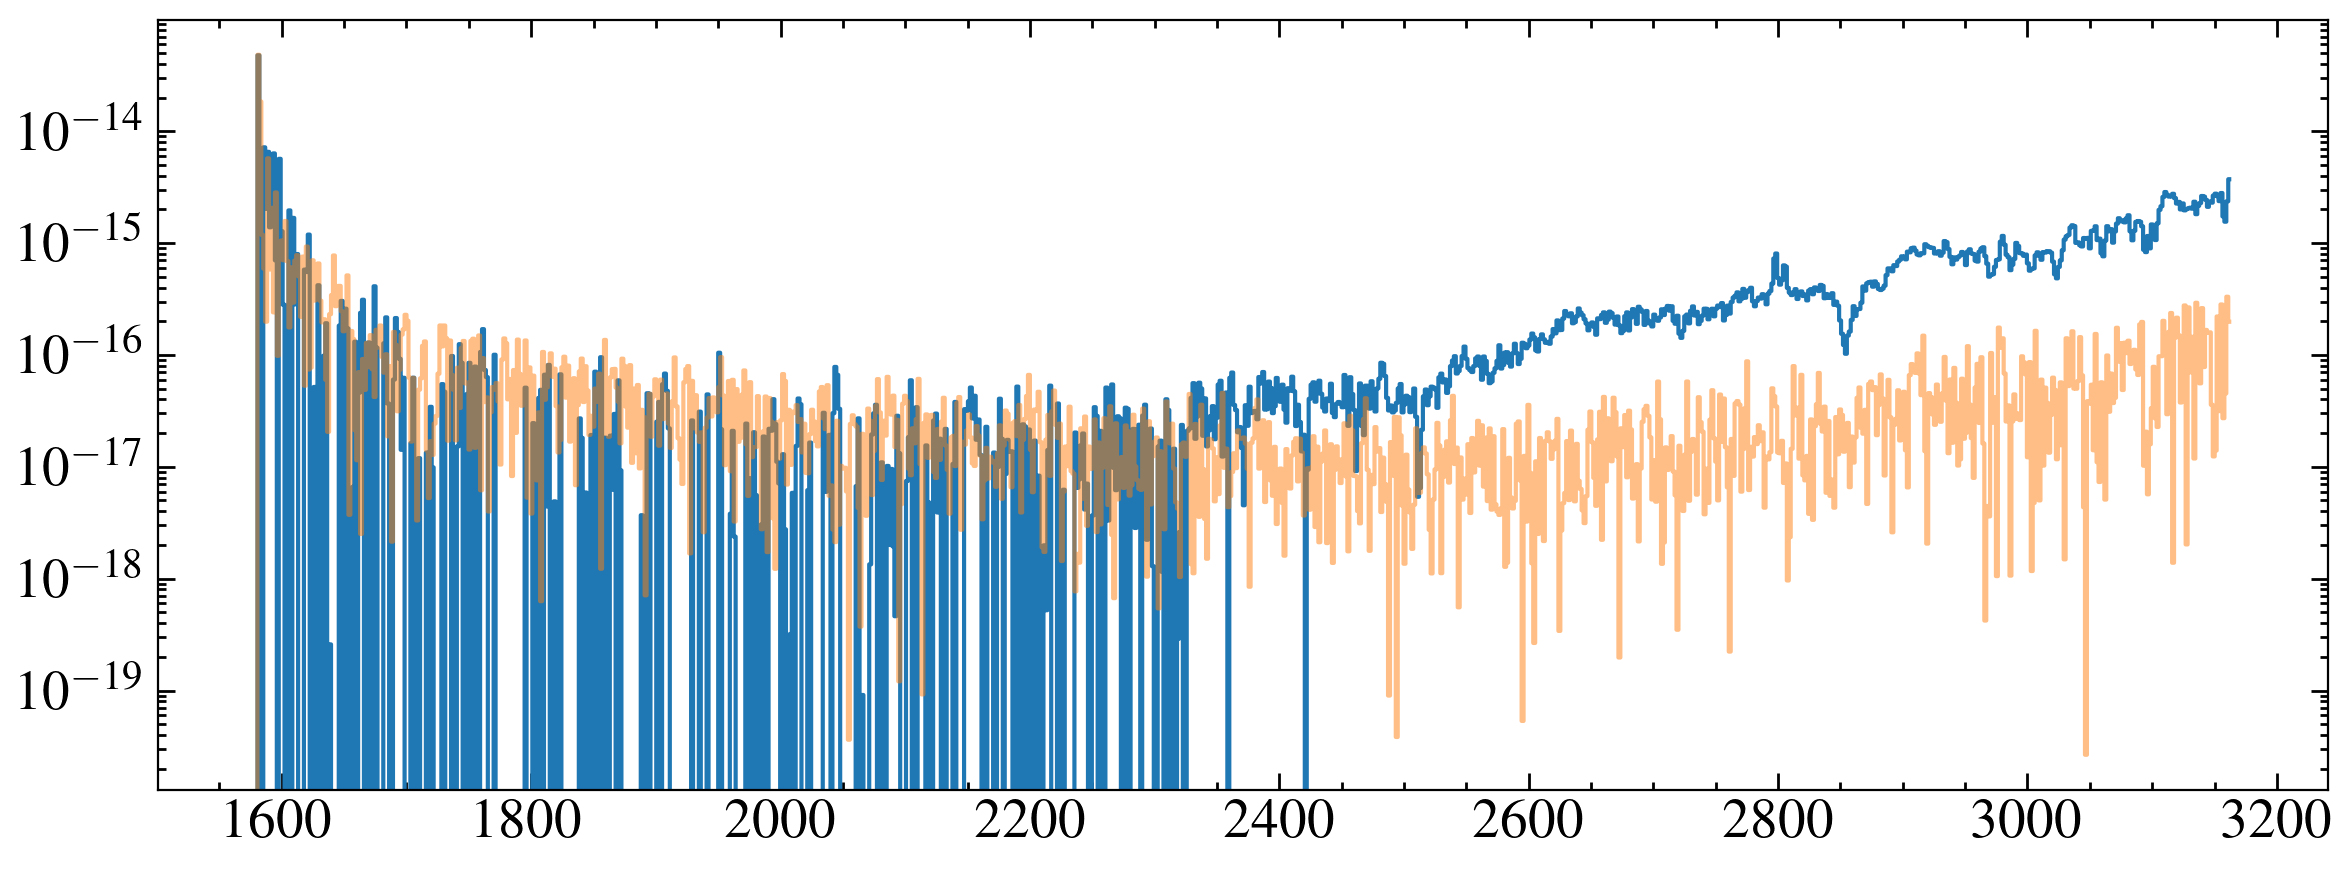

In [15]:
g230l = fits.getdata(hlsp_x1ds[0], 1)
gw, gf, ge= g230l['WAVELENGTH'], g230l['FLUX'], g230l['ERROR']

fig, ax = plt.subplots()

ax.step(gw, gf, where='mid')
ax.step(gw, ge, where='mid', alpha=0.5)

ax.set_yscale('log')

2100?

In [16]:
# norm/0.0004981318193482016
distance

128.06

Allison did a Lya estimate, check that and throw it in.

1214.0 1217.399999999997
Spectrum saved as hlsp_muscles_model_lya_hats-72_na_v1_component-spec.fits


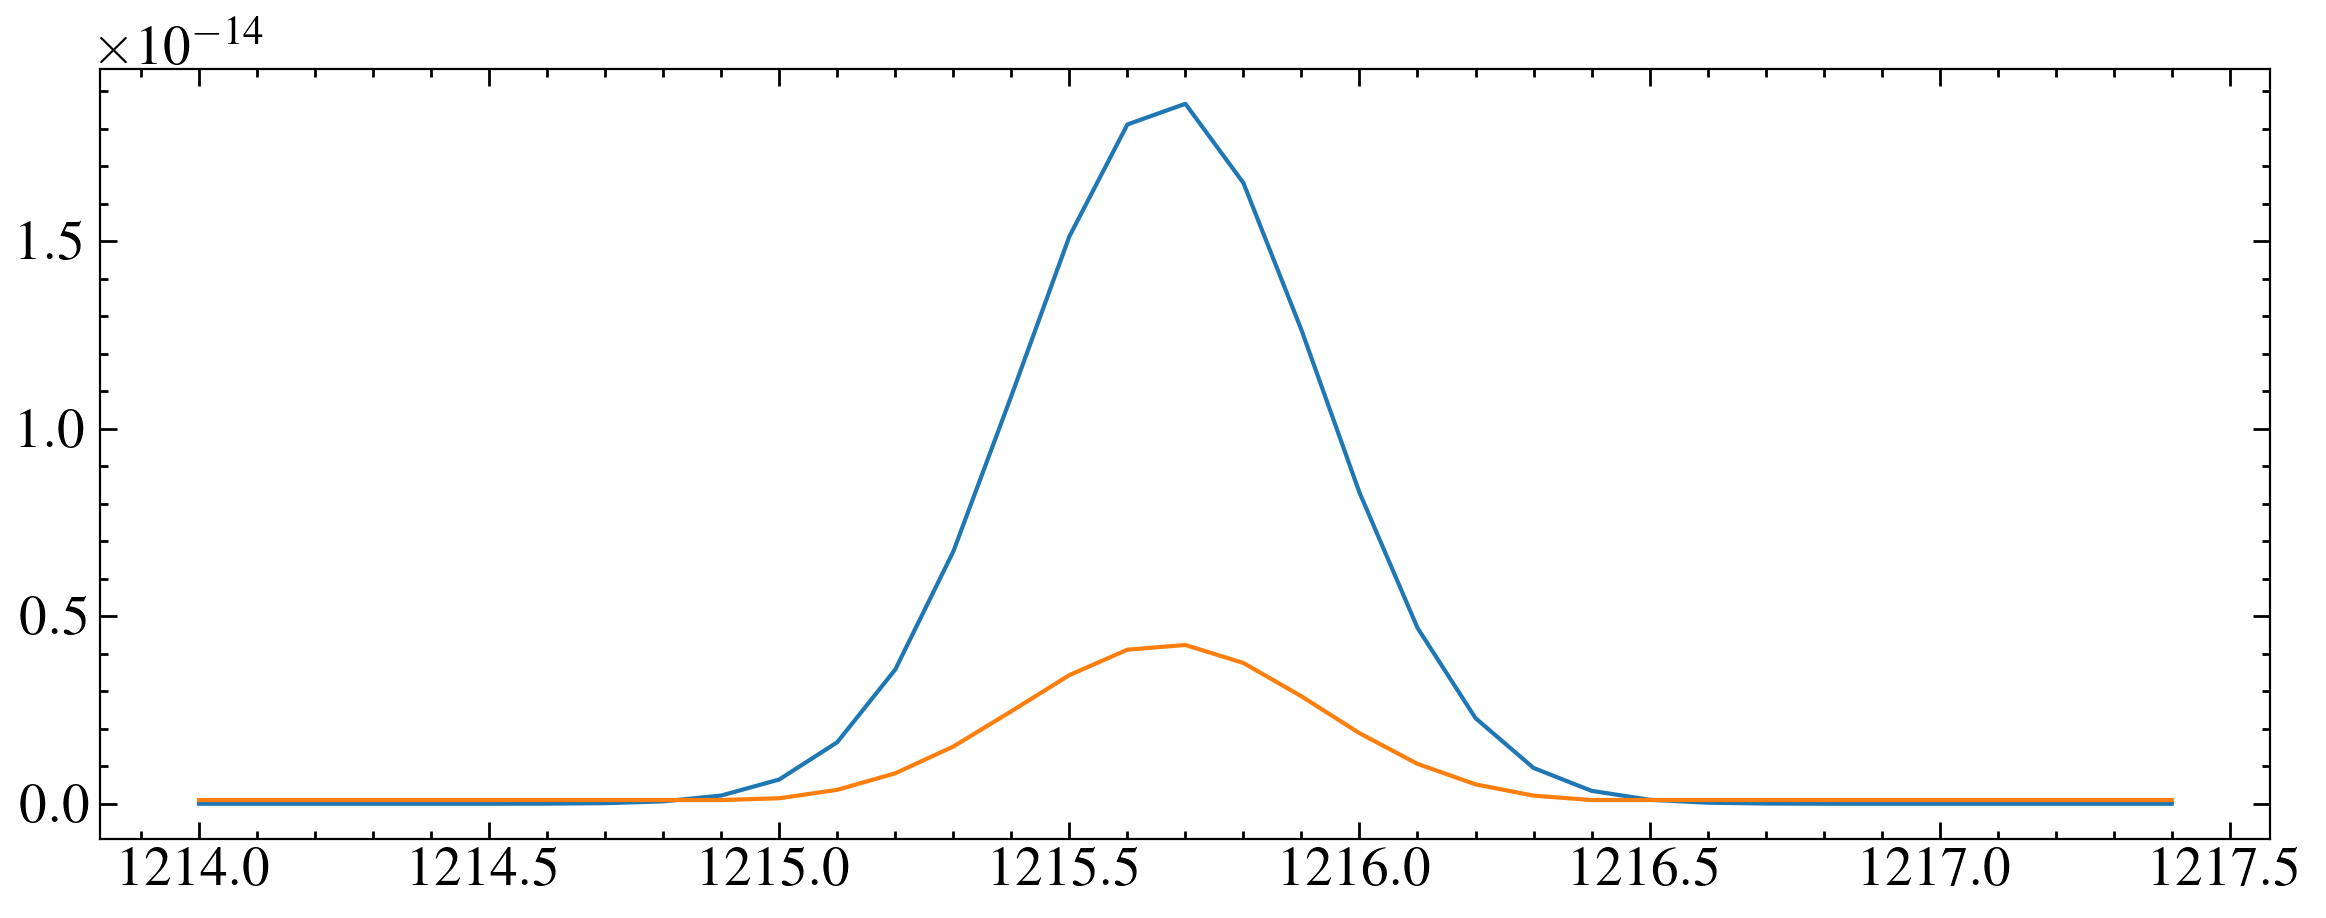

In [17]:
lyatab = Table.read('models/HATS72_LyA_estimate.txt', format='ascii.basic')
lw, lf, le = lyatab['WAVELENGTH'], lyatab['FLUX'], lyatab['ERROR']
lyatab.write('models/HATS72_LyA_estimate.ecsv', format='ascii.ecsv', overwrite=True)
plt.plot(lw, lf)
plt.plot(lw, le)
print(lw[0], lw[-1])

prepare_model.make_model_spectrum('models/HATS72_LyA_estimate.ecsv', 1, sed_data ,savepath = savepath, save_ecsv=False, save_fits=True, normfac=1, model_name='lya')


Right now it's done.

In [18]:
starspec = fits.getdata('fixed_hlsp/hats-72/hlsp_muscles_multi_multi_hats-72_broadband_v25_adapt-const-res-sed.fits', 1)
starw, starf = starspec['WAVELENGTH'], starspec['FLUX']
sol = Table.read('Solar_1au_sed.ecsv')
sw, sf = sol['WAVELENGTH'], sol['FLUX']

<>:42: SyntaxWarning: invalid escape sequence '\A'
<>:45: SyntaxWarning: invalid escape sequence '\A'
<>:59: SyntaxWarning: invalid escape sequence '\o'
<>:42: SyntaxWarning: invalid escape sequence '\A'
<>:45: SyntaxWarning: invalid escape sequence '\A'
<>:59: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_192892/2605429948.py:42: SyntaxWarning: invalid escape sequence '\A'
  ax.set_ylabel('F$_{EEID}$ (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)
/tmp/ipykernel_192892/2605429948.py:45: SyntaxWarning: invalid escape sequence '\A'
  ax1.set_xlabel('Wavelength (\AA)', size=25)
/tmp/ipykernel_192892/2605429948.py:59: SyntaxWarning: invalid escape sequence '\o'
  ax1.set_ylabel('$F_*/F_{\odot}$', size=25)


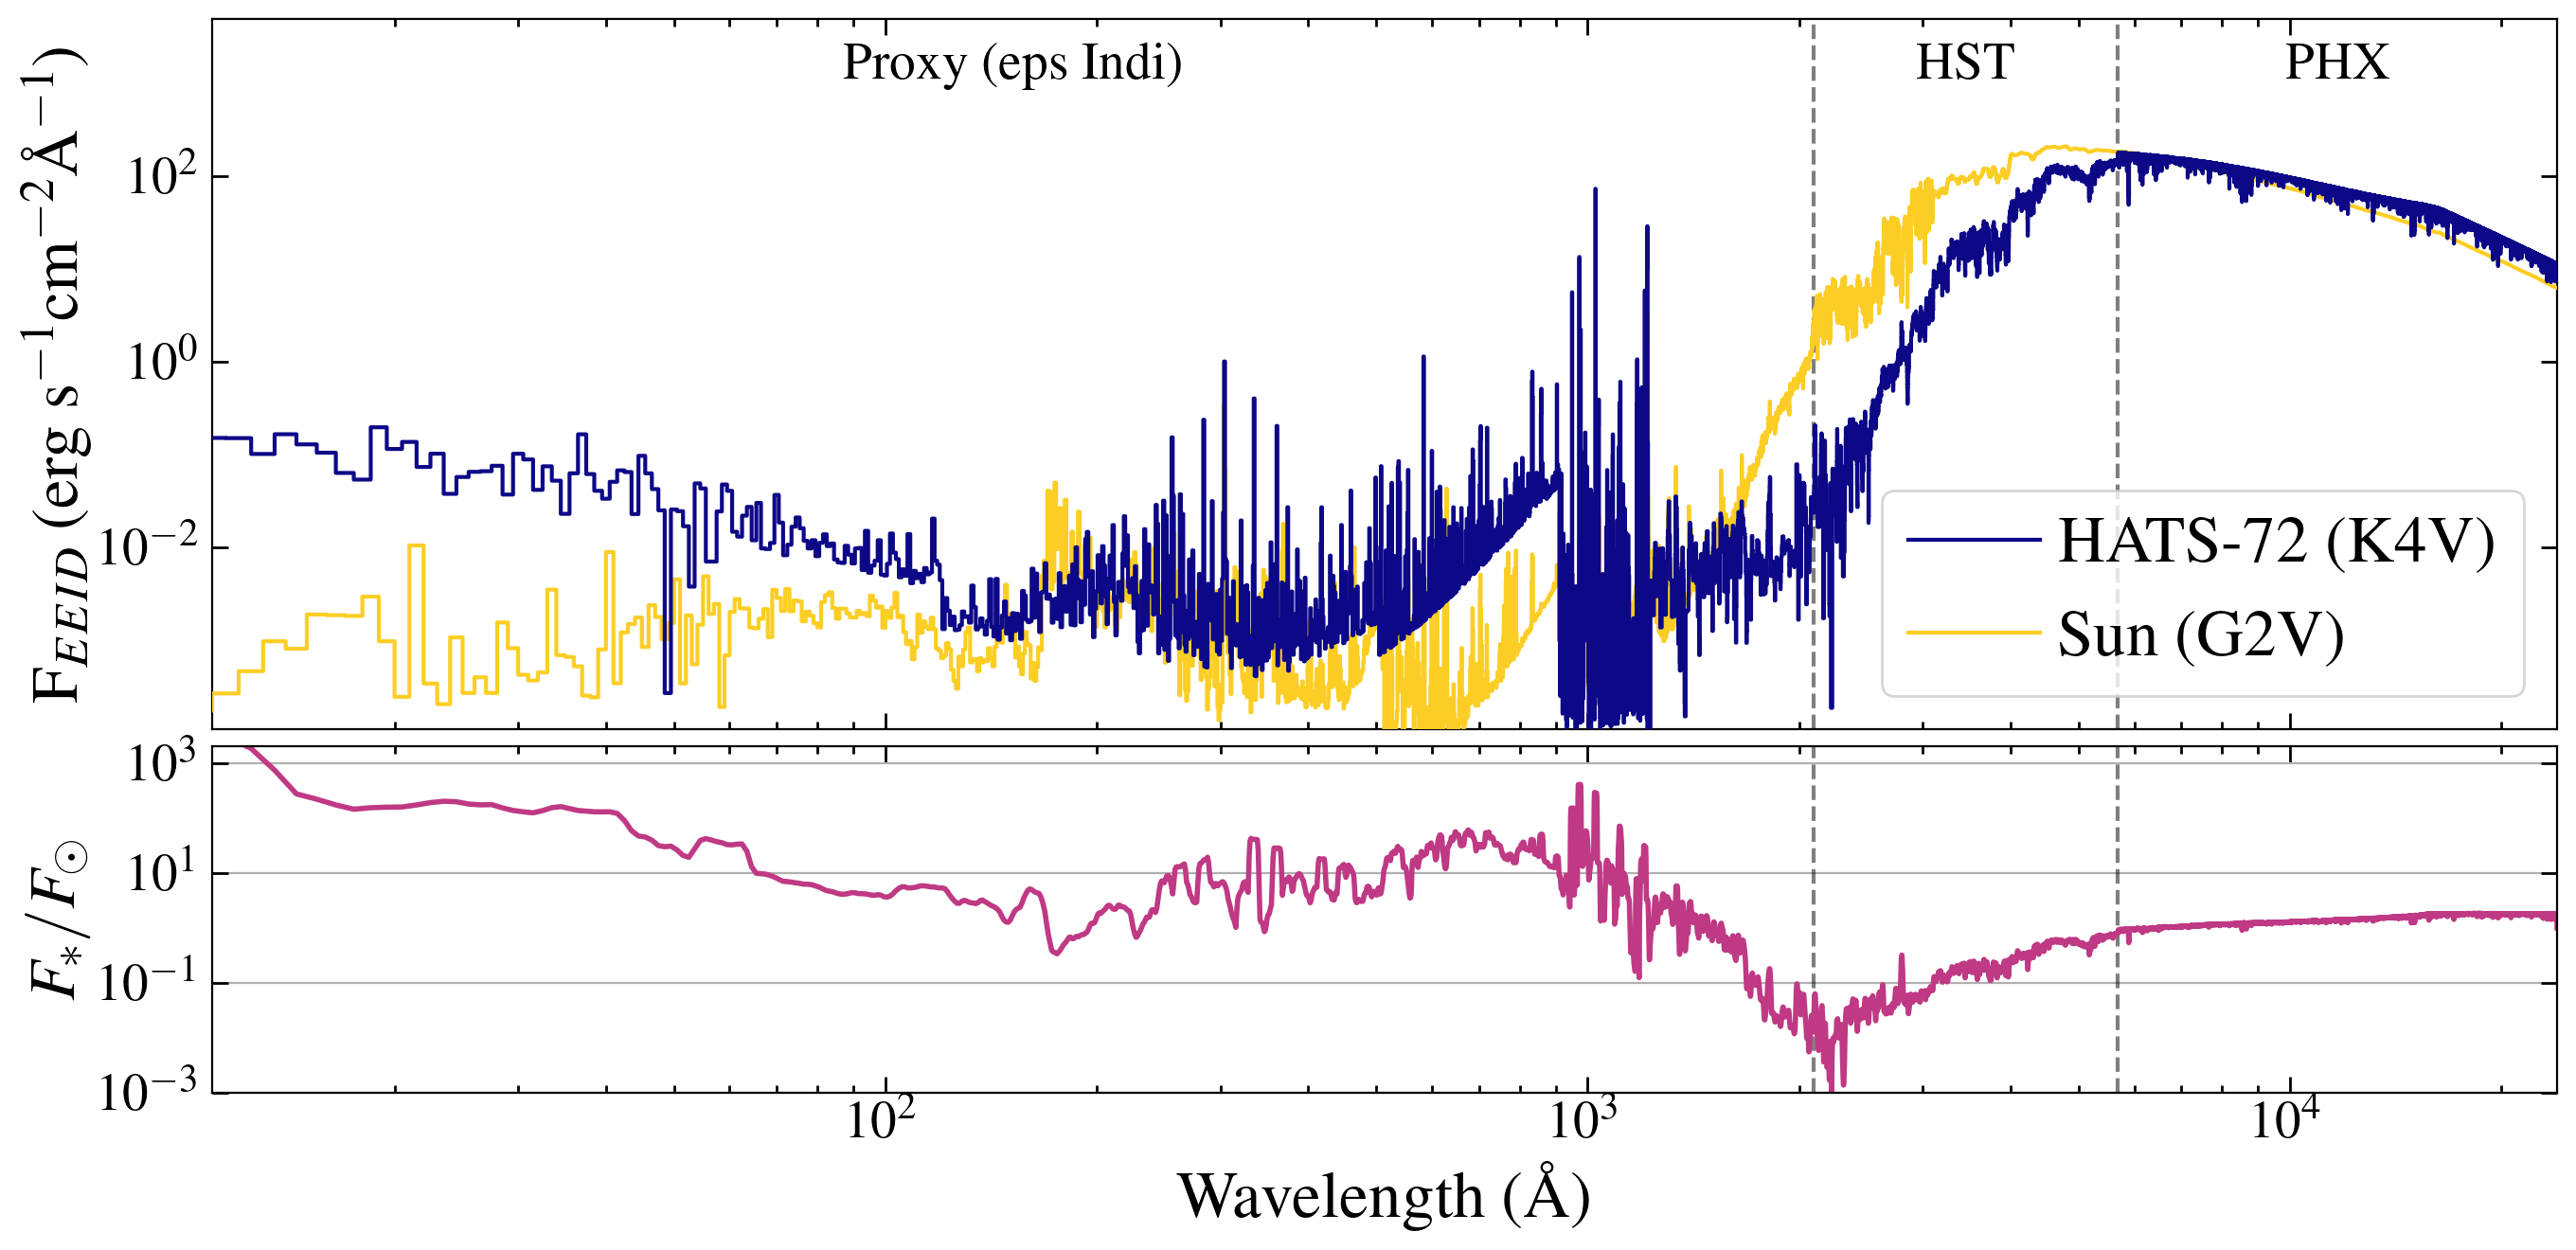

In [19]:

# cols = ['C0', 'C1', 'C2']
cols = [plt.cm.plasma(0),plt.cm.plasma(0.9), plt.cm.plasma(0.45)]

dstar = distance*u.pc
dsun = 1*u.au
lstar = 10**-0.6590
eeidau = (lstar**0.5)*1*u.au

solscale = lstar*(dsun.to(u.m)/dstar.to(u.m))**2
starscale = ((dstar.to(u.m))/(eeidau.to(u.m)))**2

fig, axes = plt.subplot_mosaic([[0,0,0],[0,0,0],[1,1,1]],figsize=(14, 7), sharex=True)


ax= axes[0]
ax.step(starw, starf*starscale, c=cols[0], label = 'HATS-72 (K4V)', zorder=12, where='mid')
ax.step(sw, sf, c=cols[1], label = 'Sun (G2V)', zorder=10, where='mid')
# ax.set_xlim(11, sw[-1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.1e-4, 4.9e3)

bar_y = 1e3
label_y = bar_y*1.5
e_y = bar_y *0.3

xlims = (11, sw[-1])
ax.set_xlim(xlims[0], xlims[1])
divlines = (2100, 5690)
[ax.axvline(line, ls='--', c='k', alpha=0.5) for line in divlines]

labels = ['Proxy (eps Indi)', 'HST', 'PHX']
labpos = np.sort(np.hstack((xlims, divlines)))

for i, label in enumerate(labels):
    label_x = (labpos[i]*labpos[i+1])**0.5
    ax.annotate(label, (label_x, label_y), ha='center', va='center')



ax.legend(fontsize=25, loc=4,frameon=True)
ax.set_ylabel('F$_{EEID}$ (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)', size=25)

ax1 = axes[1]
ax1.set_xlabel('Wavelength (\AA)', size=25)
[ax1.axvline(line, ls='--', c='k', alpha=0.5) for line in divlines]


mask = (starw> sw[0]) & (starw < sw[-1])
fnew = interp1d(starw[mask], starf[mask], fill_value='extrapolate')(sw)
fnew = fnew*starscale.value
ratio = fnew/sf
ratio = convolve(ratio,Box1DKernel(10))
ax1.plot(sw, ratio, c=cols[2], lw=2)
# ax1.set_ylim(0, 1000)

ax1.set_yscale('log')
ax1.set_ylim(1e-3, 2e3)
ax1.set_ylabel('$F_*/F_{\odot}$', size=25)
# ax1.axhline(1, ls='--', c='k', alpha=0.5)

ax1.grid(axis='y')
fig.tight_layout()
fig.subplots_adjust(hspace=0.05)


plt.savefig('plots/hats-72_v_sun.pdf')

# add the old eps_ind spec
# data = Table.read('/home/david/work/hwo/seds/eps_ind_sed_v01.txt', format='ascii.basic')
# oldw, oldf = np.loadtxt('/home/david/work/hwo/seds/eps_ind_sed_v01.txt', unpack=True)
# ax.step(oldw, oldf*starscale, c='C2', zorder=20)

20250903 looking again at flt images to see if I can get an upper limit

In [20]:
path

'/media/david/2tb_ext_hd/hddata/meats/hst/hats-72/'

In [47]:
from matplotlib.colors import LogNorm


In [86]:
# obs = ('29', '30')

# for ob in obs:
    
#     flts = glob.glob('{}*{}*0_flt.fits'.format(path, ob))
#     # print(len(flts))
#     fig, axes = plt.subplot_mosaic([[0,1,4,4],[2, 3, 4,4]], figsize=(10, 5))
#     all_flts = []
#     for i, flt in enumerate(flts):
#         data = fits.getdata(flt, 1)
#         axes[i].imshow(data, cmap=plt.cm.gray_r, norm = LogNorm(), origin='lower')
#         # print(data[[10], [10]])
#         all_flts.append(data)
#         # if i == 0:
#             # all_flts = data
#         # else:
#             # all_flts = np.stack((all_flts,data))
#     # print(all_flts.shape)
    
#     # all_flts = np.stack(np.array(all_flts))
#     all_flts = np.sum(np.array(all_flts), axis=0)
    
#     # print(all_flts.shape)
#     # print(all_flts[[10],[10]])
    
#     # all_flts = np.concatenate(all_flts, axis=2)
#     axes[4].imshow(all_flts,  cmap=plt.cm.gray_r, norm = LogNorm(), origin='lower')

#     hdul = fits.open(flts[0])
#     hdul[1].data = all_flts
#     hdul.writeto('{}/combined/visit_{}_combined_flt.fits'.format(path, ob), overwrite=True)
#     hdul.close()


# # fig.tight_layout()
# # all_flts


Nothing in the combined flt images. Upper limits - sum extracted errorbars and see if the proxy is under them

In [125]:
starspec = fits.getdata('fixed_hlsp/hats-72/hlsp_muscles_multi_multi_hats-72_broadband_v25_var-res-sed.fits', 1)
starw, starf = starspec['WAVELENGTH'], starspec['FLUX']

/tmp/ipykernel_192892/233004906.py:17: RuntimeWarning: divide by zero encountered in divide
  meane = meanf * np.sum((abs(es/fs))**2, axis=0)**0.5
/tmp/ipykernel_192892/233004906.py:17: RuntimeWarning: invalid value encountered in divide
  meane = meanf * np.sum((abs(es/fs))**2, axis=0)**0.5
/tmp/ipykernel_192892/233004906.py:17: RuntimeWarning: invalid value encountered in multiply
  meane = meanf * np.sum((abs(es/fs))**2, axis=0)**0.5


4.2234912e-17
1716.577817119371


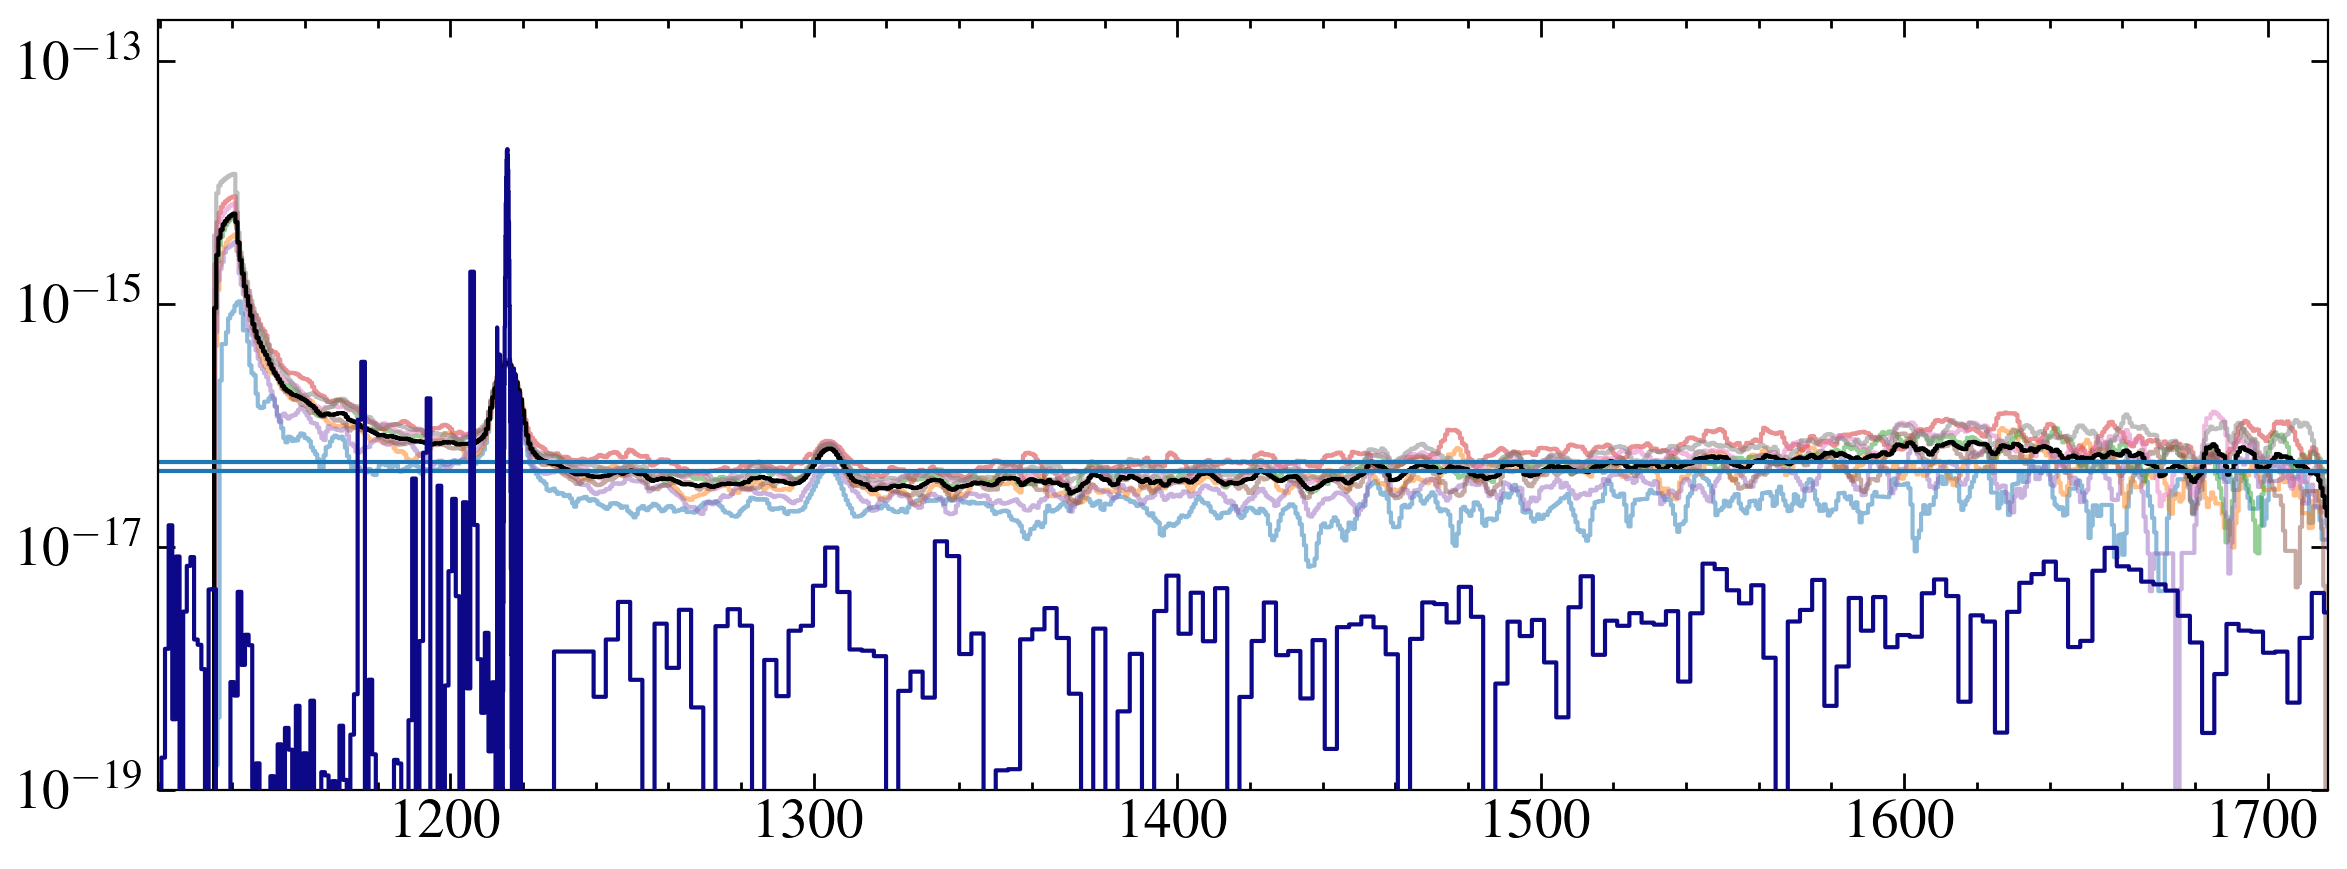

In [132]:

fig, ax = plt.subplots()

fs = []
es = []

for x in g140ls:
    data = fits.getdata(x, 1)[0]
    # print(data['A2Center'])
    w, f, e= data['WAVELENGTH'], data['FLUX'], data['ERROR']
    fs.append(f)
    e = convolve(e, Box1DKernel(10))
    es.append(e)
    ax.step(w, e, alpha=0.5, where='mid')
fs, es = np.array(fs), np.array(es)

meanf = np.mean(fs, axis=0)
meane = meanf * np.sum((abs(es/fs))**2, axis=0)**0.5

meane2 = np.mean(es, axis=0) #treating it as a flux measurement =

# ax.step(w, meane, where='mid', c='k')
ax.step(w, meane2, where='mid', c='k')
ax.set_yscale('log')


ax.step(starw, starf, c=cols[0], label = 'HATS-72 (K4V)', zorder=12, where='mid')

ax.set_xlim(w[0], w[-1])

print(np.median(meane2[w > 1220]))
ax.axhline(np.median(meane2[w > 1230]))
ax.axhline(5e-17)

ax.set_ylim(1e-19)
print(w[-1])